<h1 align="center">Walmart Demand Forecasting</h1>

<h4 align="center">Domain: Demand Forecasting</h4>

**Dataset Name**: Walmart Dataset

**Description**: This dataset provides historical sales data for 45 Walmart stores located in different regions. The dataset covers 2010-02-05 to 2012-11-01 and includes various economic factors and holiday information that might affect sales. Walmart seeks to improve sales and demand prediction accuracy using machine learning. Key challenges include modeling the impact of promotional markdown events preceding major holidays like the Super Bowl, Labor Day, Thanksgiving, and Christmas, which significantly influence sales. The dataset aims to enhance forecasting capabilities amidst fluctuating demand and economic conditions.

**Source**: The dataset is sourced from Kaggle [link](https://www.kaggle.com/datasets/yasserh/walmart-dataset/data)

**Objective**: The goal of this analysis is to understand the key factors that influence sales at Walmart stores and to develop a model that accurately predicts future sales. This model can help Walmart optimize inventory management, staffing, and marketing strategies.

## Explanation of Each Column:

| Column Name       | Description                                              | Data Type | Notes                               |
|-------------------|----------------------------------------------------------|-----------|-------------------------------------|
| Store             | Unique identifier for each store                         | Integer | Distinguishes sales data across different Walmart stores |
| Date              | Date of the sales data                                   | Object to be converted to datetime64[ns]  | Indicates the week of sales |
| Weekly_Sales      | Sales recorded for the given store for that week | Float | Target variable for the predictive model |
| Holiday_Flag         | Indicator for whether the week includes a major holiday  | Integer | Affects sales patterns 1=Holiday week 0=Non-hoiday week|
| Temperature       | Average temperature for the region during that week      | Float | Provides insights into how weather conditions impact sales |
| Fuel_Price        | Cost of fuel in the region for that week                 | Float | Can influence consumer spending behavior |
| CPI               | Consumer Price Index                                     | Float | Represents the relative cost of consumer goods and services, impacting purchasing power |
| Unemployment      | Unemployment rate in the region for that week            | Float | Higher unemployment rates might negatively affect sales |
| Year          | Year of the sales data                                   | Integer   | Extracted from the Date column after conversion |
| Month         | Month of the sales data                                  | Integer   | Extracted from the Date column after conversion |
| Day           | Day of the sales data                                    | Integer   | Extracted from the Date column after conversion |
| WeekOfYear    | ISO week date system: week number of the sales data                        | Integer   | Extracted from the Date column after conversion |

###Visual inspection of the data

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform, stats
from joblib import dump

# Function to load data
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

# Call the load_data function
df = load_data('Walmart.csv')

In [9]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


###Exploratory Data Analysis (EDA)

In [10]:
# Dataframe Information
print("Dataframe Information:")
print(df.info())
print()

# Date is 2010-02-05 object-we need to convert it to datetime format in order to extract later
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') # converts object(string) format to datetime format
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Dataframe Information check after date conversion
print("Dataframe Information with Date converted:")
print(df.info())

# Check for missing values
missing_values = df.isnull().sum().sum()  # Total number of missing values in the DataFrame
print()
if missing_values == 0:
    print("There are no missing values in the DataFrame.")
else:
    print(f"There are {missing_values} missing values in the DataFrame.")
print()

#Check for duplicates
duplicate_rows = df[df.duplicated()]
if not duplicate_rows.empty:
    print("Duplicate rows found in the DataFrame:")
    print(duplicate_rows)
else:
    print("No duplicate rows found in the DataFrame.")
print()

# Check for unique values (Store and Holiday_Flag expected to have unique identifier; Year, Month, day, WeekOfYear derived from Date
# are used for time-series analysis, trends, patterns, etc so need to ensure uniqueness here. Other columns are
# continuous or categorical that do not require unique check)
columns_to_check_unique = ['Store', 'Holiday_Flag','Year', 'Month', 'Day', 'WeekOfYear']
for col in columns_to_check_unique:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}':")
    print(unique_values)
    print()

# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe())
print()

# Check for outliers - numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
# Using IQR method for each numerical column
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if not outliers.empty:
        print(f"Column '{col}' has {len(outliers)} outliers according to IQR method.")
print()


Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None

Dataframe Information with Date converted:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  64

**Descriptive Statistics Summary:**

---
Store has a mean of 23 suggesting the dataset covers a range of stores with each contributing around the same on average. It is a distribution that indicates the sales data is fairly represented across the 45 stores that are included.

Outcome variable: Weekly_Sales has a mean ~1,046,965 dollars with a standard deviation of ~$564,366. The range is 209,986-3,818,686 suggesting a broad range of variability/weekly sales. The diversity here across the different weeks may be influenced by other factors.

Holiday_Flag shows a mean of ~7% of sales are conducted on a holiday with a low .255 standard deviation which implies it is consistent but somewhat of a minor impact on sales compared to the non-holiday weeks.

Temperature and Economic factors: The average temperature is ~60.66 degrees and may help in understanding seasonal variations in consumer behiavior and/or sales patterns. Fuel_Price has a mean of ~3.36, CPI is ~171.58, Unemployment ~8.

Date Components: Month, Day and WeekOfYear suggests the average peak sales are around mid June, the 25th week of the year.


**Outliers**

---

Column 'Weekly_Sales' has 34 outliers according to IQR method.<br>
Column 'Holiday_Flag' has 450 outliers according to IQR method.<br>
Column 'Temperature' has 3 outliers according to IQR method.<br>
Column 'Unemployment' has 481 outliers according to IQR method.<br>

We will look to reason and plot:


####Outliers

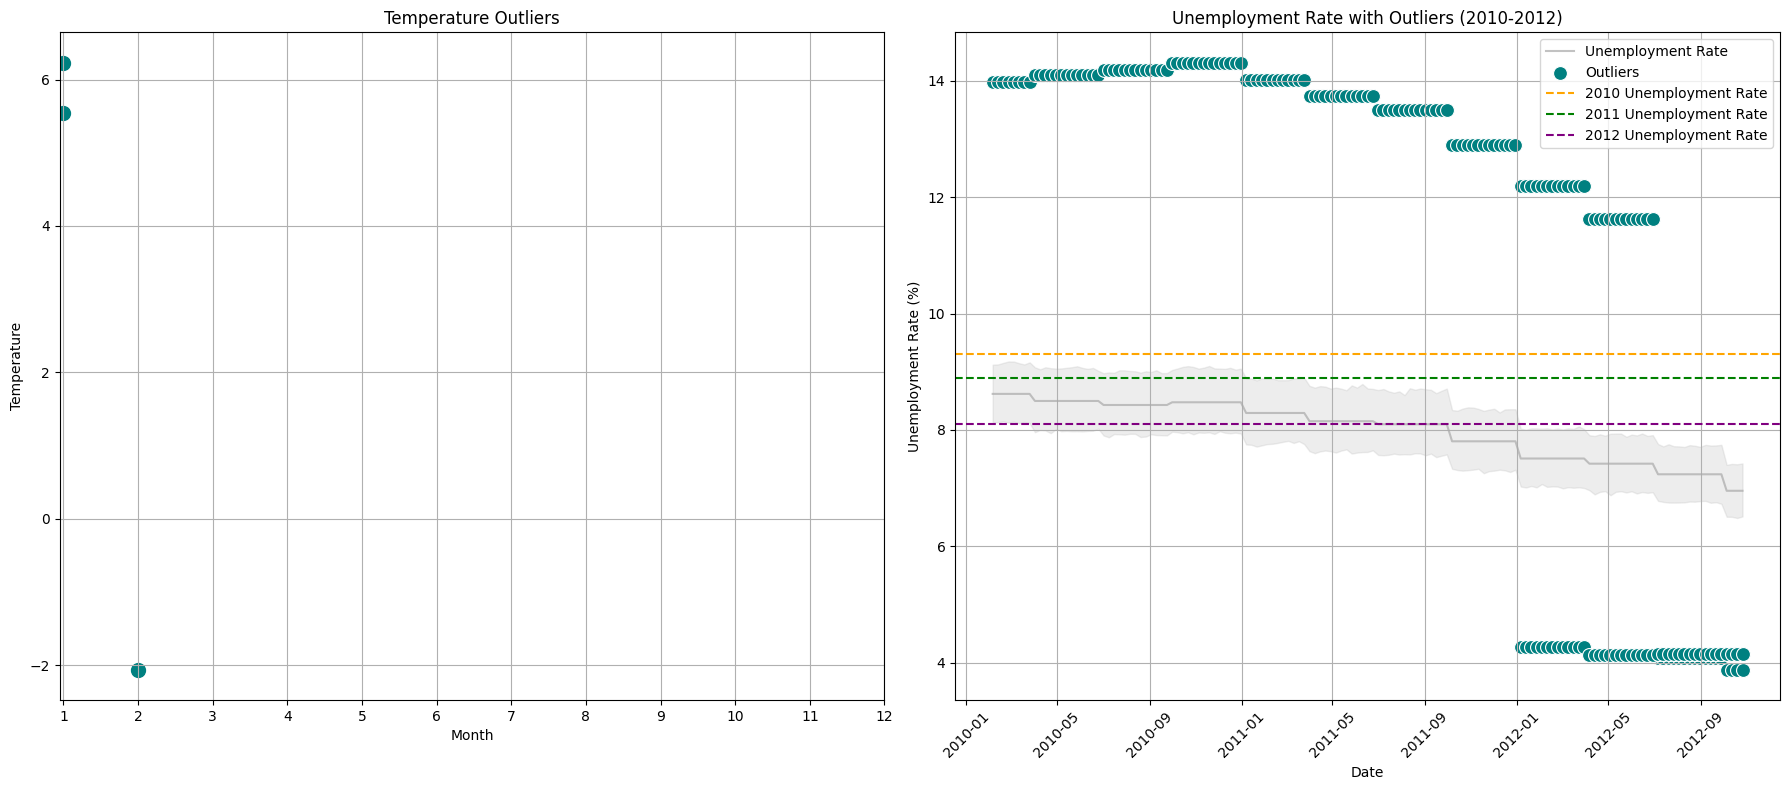

In [11]:
# Filter outliers in the Temperature column using IQR method
Q1_temp = df['Temperature'].quantile(0.25)
Q3_temp = df['Temperature'].quantile(0.75)
IQR_temp = Q3_temp - Q1_temp
lower_bound_temp = Q1_temp - 1.5 * IQR_temp
upper_bound_temp = Q3_temp + 1.5 * IQR_temp

temperature_outliers = df[(df['Temperature'] < lower_bound_temp) | (df['Temperature'] > upper_bound_temp)]

# Filter outliers in the Unemployment column using IQR method
Q1_unemployment = df['Unemployment'].quantile(0.25)
Q3_unemployment = df['Unemployment'].quantile(0.75)
IQR_unemployment = Q3_unemployment - Q1_unemployment
lower_bound_unemployment = Q1_unemployment - 1.5 * IQR_unemployment
upper_bound_unemployment = Q3_unemployment + 1.5 * IQR_unemployment

unemployment_outliers = df[(df['Unemployment'] < lower_bound_unemployment) | (df['Unemployment'] > upper_bound_unemployment)]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plotting the temperature outliers
ax1.scatter(temperature_outliers['Month'], temperature_outliers['Temperature'], color='#008080', marker='o', s=100)  # Teal color
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature')
ax1.set_title('Temperature Outliers')
ax1.grid(True)
ax1.set_xticks(range(1, 13))

# Plotting the unemployment outliers
sns.lineplot(data=df, x='Date', y='Unemployment', label='Unemployment Rate', color='#A9A9A9', alpha=0.7, ax=ax2)  # Grey color
sns.scatterplot(data=unemployment_outliers, x='Date', y='Unemployment', color='#008080', label='Outliers', s=100, ax=ax2)  # Pale lavender color

# Mark significant periods based on historical data
ax2.axhline(y=9.3, color='orange', linestyle='--', label='2010 Unemployment Rate')
ax2.axhline(y=8.9, color='green', linestyle='--', label='2011 Unemployment Rate')
ax2.axhline(y=8.1, color='purple', linestyle='--', label='2012 Unemployment Rate')

ax2.set_xlabel('Date')
ax2.set_ylabel('Unemployment Rate (%)')
ax2.set_title('Unemployment Rate with Outliers (2010-2012)')
ax2.legend()
ax2.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()



Column 'Temperature' has 3 outliers we will keep. It is reasonable that some months are colder year to year and these 3 outliers are showing up in January and February.

Column 'Unemployment' has 481 outliers. According to [statista.com](https://www.statista.com/statistics/193290/unemployment-rate-in-the-usa-since-1990/) there was high unemployment rate during the time of this dataset of:
2010 9.3%, 2011 8.9%, 2012 8.1%. Given that the period (2010-02-05 to 2012-11-01) includes years with high unemployment rates, a large number of outliers might reflect genuine economic conditions rather than errors. We will keep the outliers to preserve data integrity and complexity of the dataset as they may provide insights into unusual or significant economic events or trends needed for analysis.


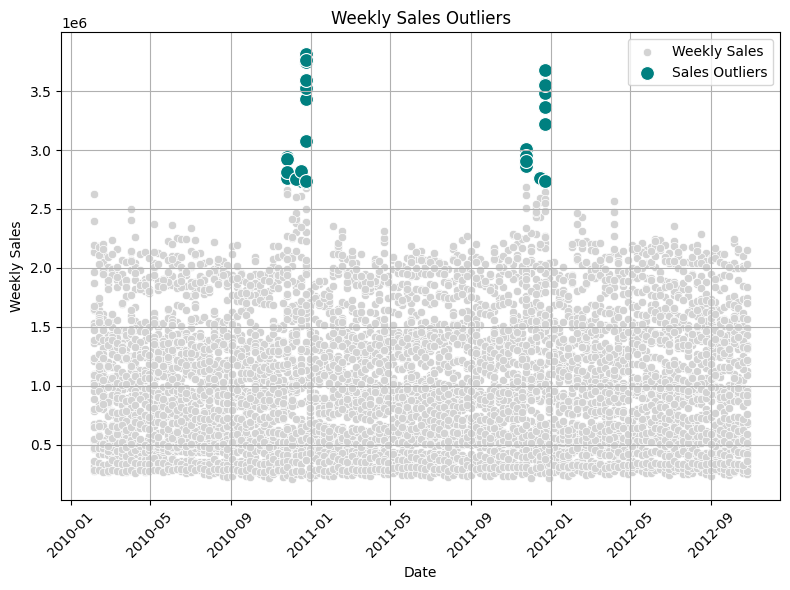

In [12]:
# 'Weekly_Sales' column
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Defining the upper bound for outliers based on IQR
upper_bound_sales = Q3 + 1.5 * IQR

# Filtering outliers in weekly sales
sales_outliers = df[df['Weekly_Sales'] > upper_bound_sales]

# Plotting only the Weekly Sales outliers
plt.figure(figsize=(8, 6))

# Plot all Weekly Sales data
sns.scatterplot(x='Date', y='Weekly_Sales', data=df, color='lightgray', label='Weekly Sales')

# Plotting outliers in teal
sns.scatterplot(x='Date', y='Weekly_Sales', data=sales_outliers, color='teal', label='Sales Outliers', s=100)

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Outliers')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Column 'Weekly_Sales' has 34 outliers that appear to be tied to the Thanksgiving/Christmas shopping season in November/December suggesting this is when sales spike and are to be expected. This reinforces the known that weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. For this reason, we will keep the outliers.

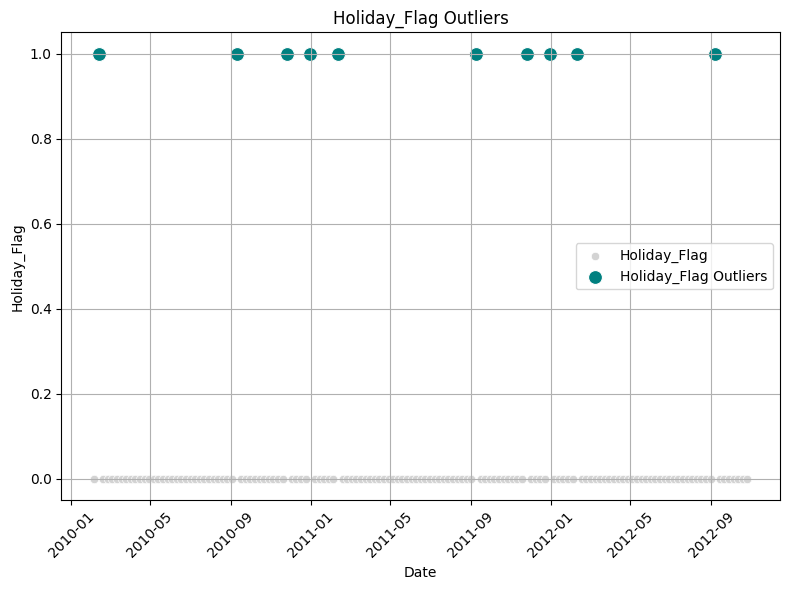

Number of outliers in Holiday_Flag: 450
Percentage of outliers in Holiday_Flag: 6.99%


In [13]:
# Calculate outliers based on IQR method for 'Holiday_Flag'
Q1 = df['Holiday_Flag'].quantile(0.25)
Q3 = df['Holiday_Flag'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers for 'Holiday_Flag'
holiday_flag_outliers = df[(df['Holiday_Flag'] < (Q1 - 1.5 * IQR)) | (df['Holiday_Flag'] > (Q3 + 1.5 * IQR))]

# Plotting outliers in Holiday_Flag column
plt.figure(figsize=(8, 6))

# Plot all data points
sns.scatterplot(x='Date', y='Holiday_Flag', data=df, color='lightgray', label='Holiday_Flag')

# Plot outliers
sns.scatterplot(x='Date', y='Holiday_Flag', data=holiday_flag_outliers, color='teal', label='Holiday_Flag Outliers', s=100)

plt.xlabel('Date')
plt.ylabel('Holiday_Flag')
plt.title('Holiday_Flag Outliers')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print statistical summary and insights
print("Number of outliers in Holiday_Flag:", len(holiday_flag_outliers))
percentage_outliers = len(holiday_flag_outliers) / len(df) * 100
print("Percentage of outliers in Holiday_Flag: {:.2f}%".format(percentage_outliers))

Column 'Holiday_Flag' has 450 outliers. The 6.99% of outliers in Holiday_Flag indicates a small proportion to the total dataset. This suggests they may represent specific events or conditions and will be kept at this time.

####Correlation Matrix

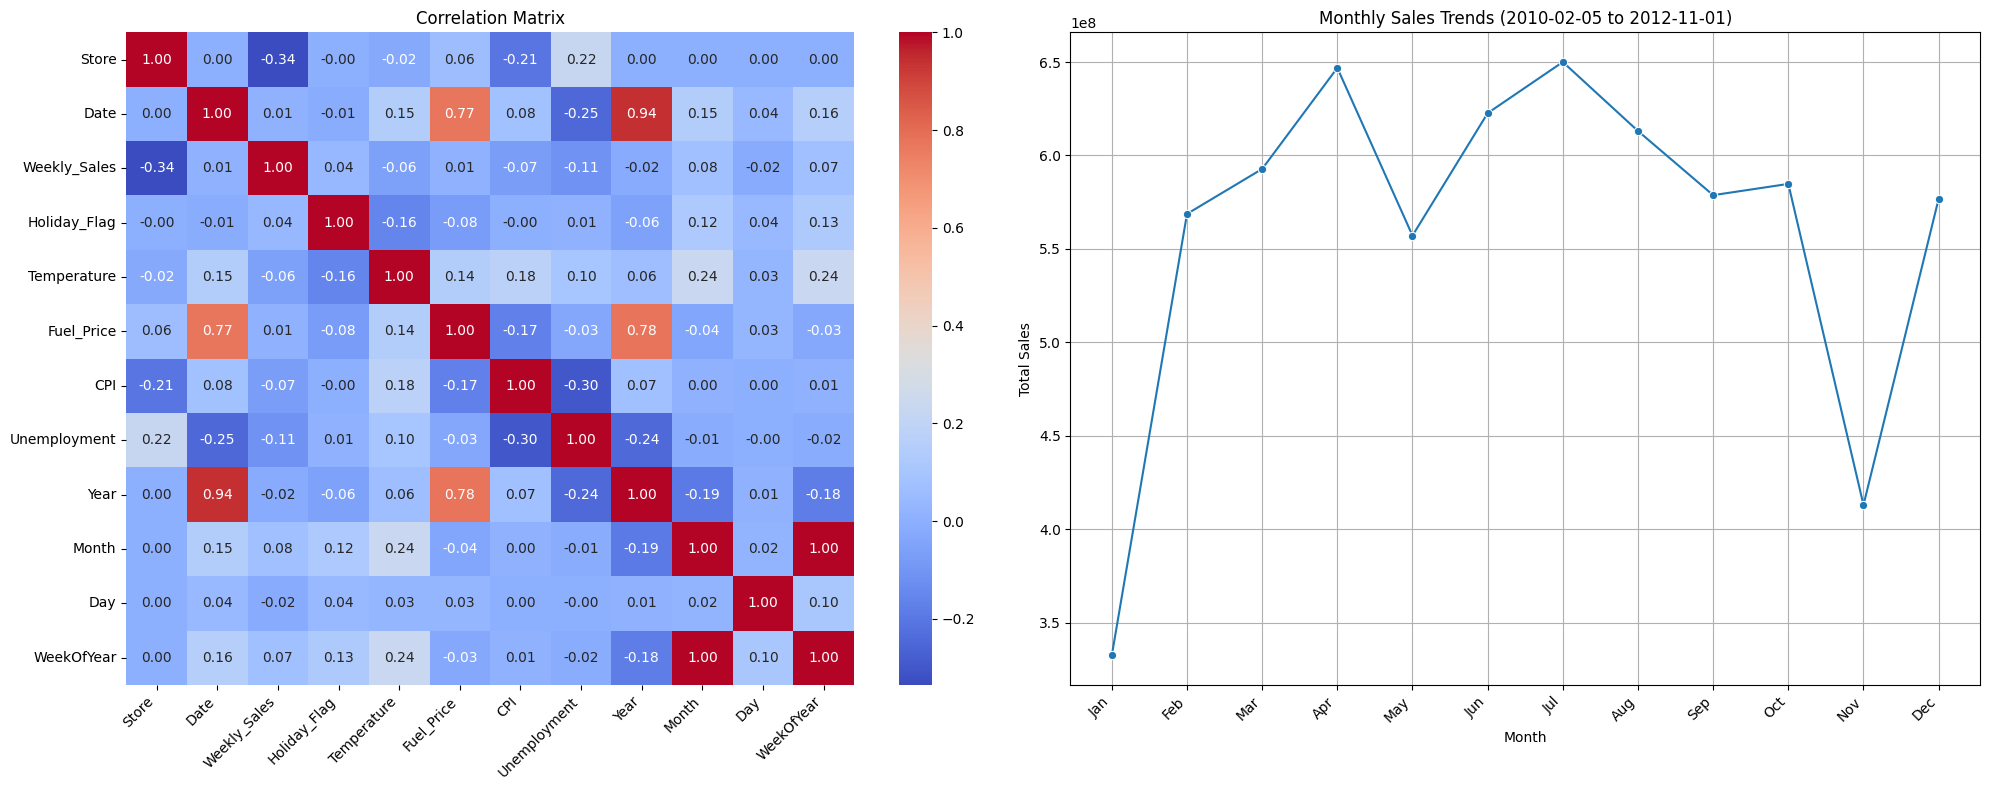

Correlation Summaries:
Fuel_Price and Date: There is a high correlation (0.7714).
Year and Date: There is a high correlation (0.9417).
Year and Fuel_Price: There is a high correlation (0.7795).
WeekOfYear and Month: There is a high correlation (0.9960).

Variance for each numeric column:
Store           1.686929e+02
Weekly_Sales    3.185097e+11
Holiday_Flag    6.504996e-02
Temperature     3.402155e+02
Fuel_Price      2.106991e-01
CPI             1.548951e+03
Unemployment    3.518944e+00
dtype: float64


In [14]:
# Correlation matrix visualization
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))  # Adjust figsize as needed
plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix')

# Monthly sales trends visualization
plt.subplot(1, 2, 2)
monthly_sales = df.groupby('Month')['Weekly_Sales'].sum()
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trends (2010-02-05 to 2012-11-01)')
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Define thresholds for interpreting correlations
moderate_corr_threshold = 0.5
high_corr_threshold = 0.7

# Function to summarize correlations
def summarize_correlations(corr_matrix):
    print("Correlation Summaries:")
    visited_pairs = set()  # To keep track of visited pairs
    for i, col in enumerate(corr_matrix.columns):
        for j, row in enumerate(corr_matrix.index):
            if i != j:  # Exclude self-correlation (diagonal elements)
                pair = tuple(sorted([row, col]))  # Sort pair to avoid duplicate output
                if pair not in visited_pairs:
                    visited_pairs.add(pair)
                    correlation = corr_matrix.loc[row, col]  # Access correlation value
                    if abs(correlation) >= high_corr_threshold:
                        print(f"{row} and {col}: There is a high correlation ({correlation:.4f}).")
                    elif abs(correlation) >= moderate_corr_threshold:
                        print(f"{row} and {col}: There is a moderate correlation ({correlation:.4f}).")

# Print correlation summaries
summarize_correlations(correlation_matrix)
print()

# Variance
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate variance for each numeric column
variances = df[numeric_cols].var()

# Print or inspect the variances
print("Variance for each numeric column:")
print(variances)

**Correlation Summaries at this point:**

---

Fuel_Price and Date: There is a high correlation (0.7714).<br>
Year and Date: There is a high correlation (0.9417).<br>
Year and Fuel_Price: There is a high correlation (0.7795).<br>
WeekOfYear and Month: There is a high correlation (0.9960).<br>

Sales Trends: Peak in April and July. May be seasonal crucial for planning inventory, promotions, staffing during this time, or it may not as our 2010 data does not include January and our 2012 does not include December.

**Variance:**

---

High variance: CPI at 1548.95 suggests significant variability across the dataset and that consumer prices vary widely across time or regions. Weekly_Sales has a high variance showing a possible wide range of weekly sales and that they may vary from week to week or store to store.

Low variance: Holiday_Flag at .065 reflects little variability and consistent values.

Moderate variance: The remainder show a moderate outcome reflecting varying significance across the dataset.

**Investigate per year where and when the most sales occur.**

---

This is conducted because in the dataset 2010 does not include January, and 2012 does not include December. To view the weekly sales we will use aggregated metrics as it provides the overall trend of the total sales over time and simplifies the visualization by summarizing the data.

No dates categorized as Unknown.


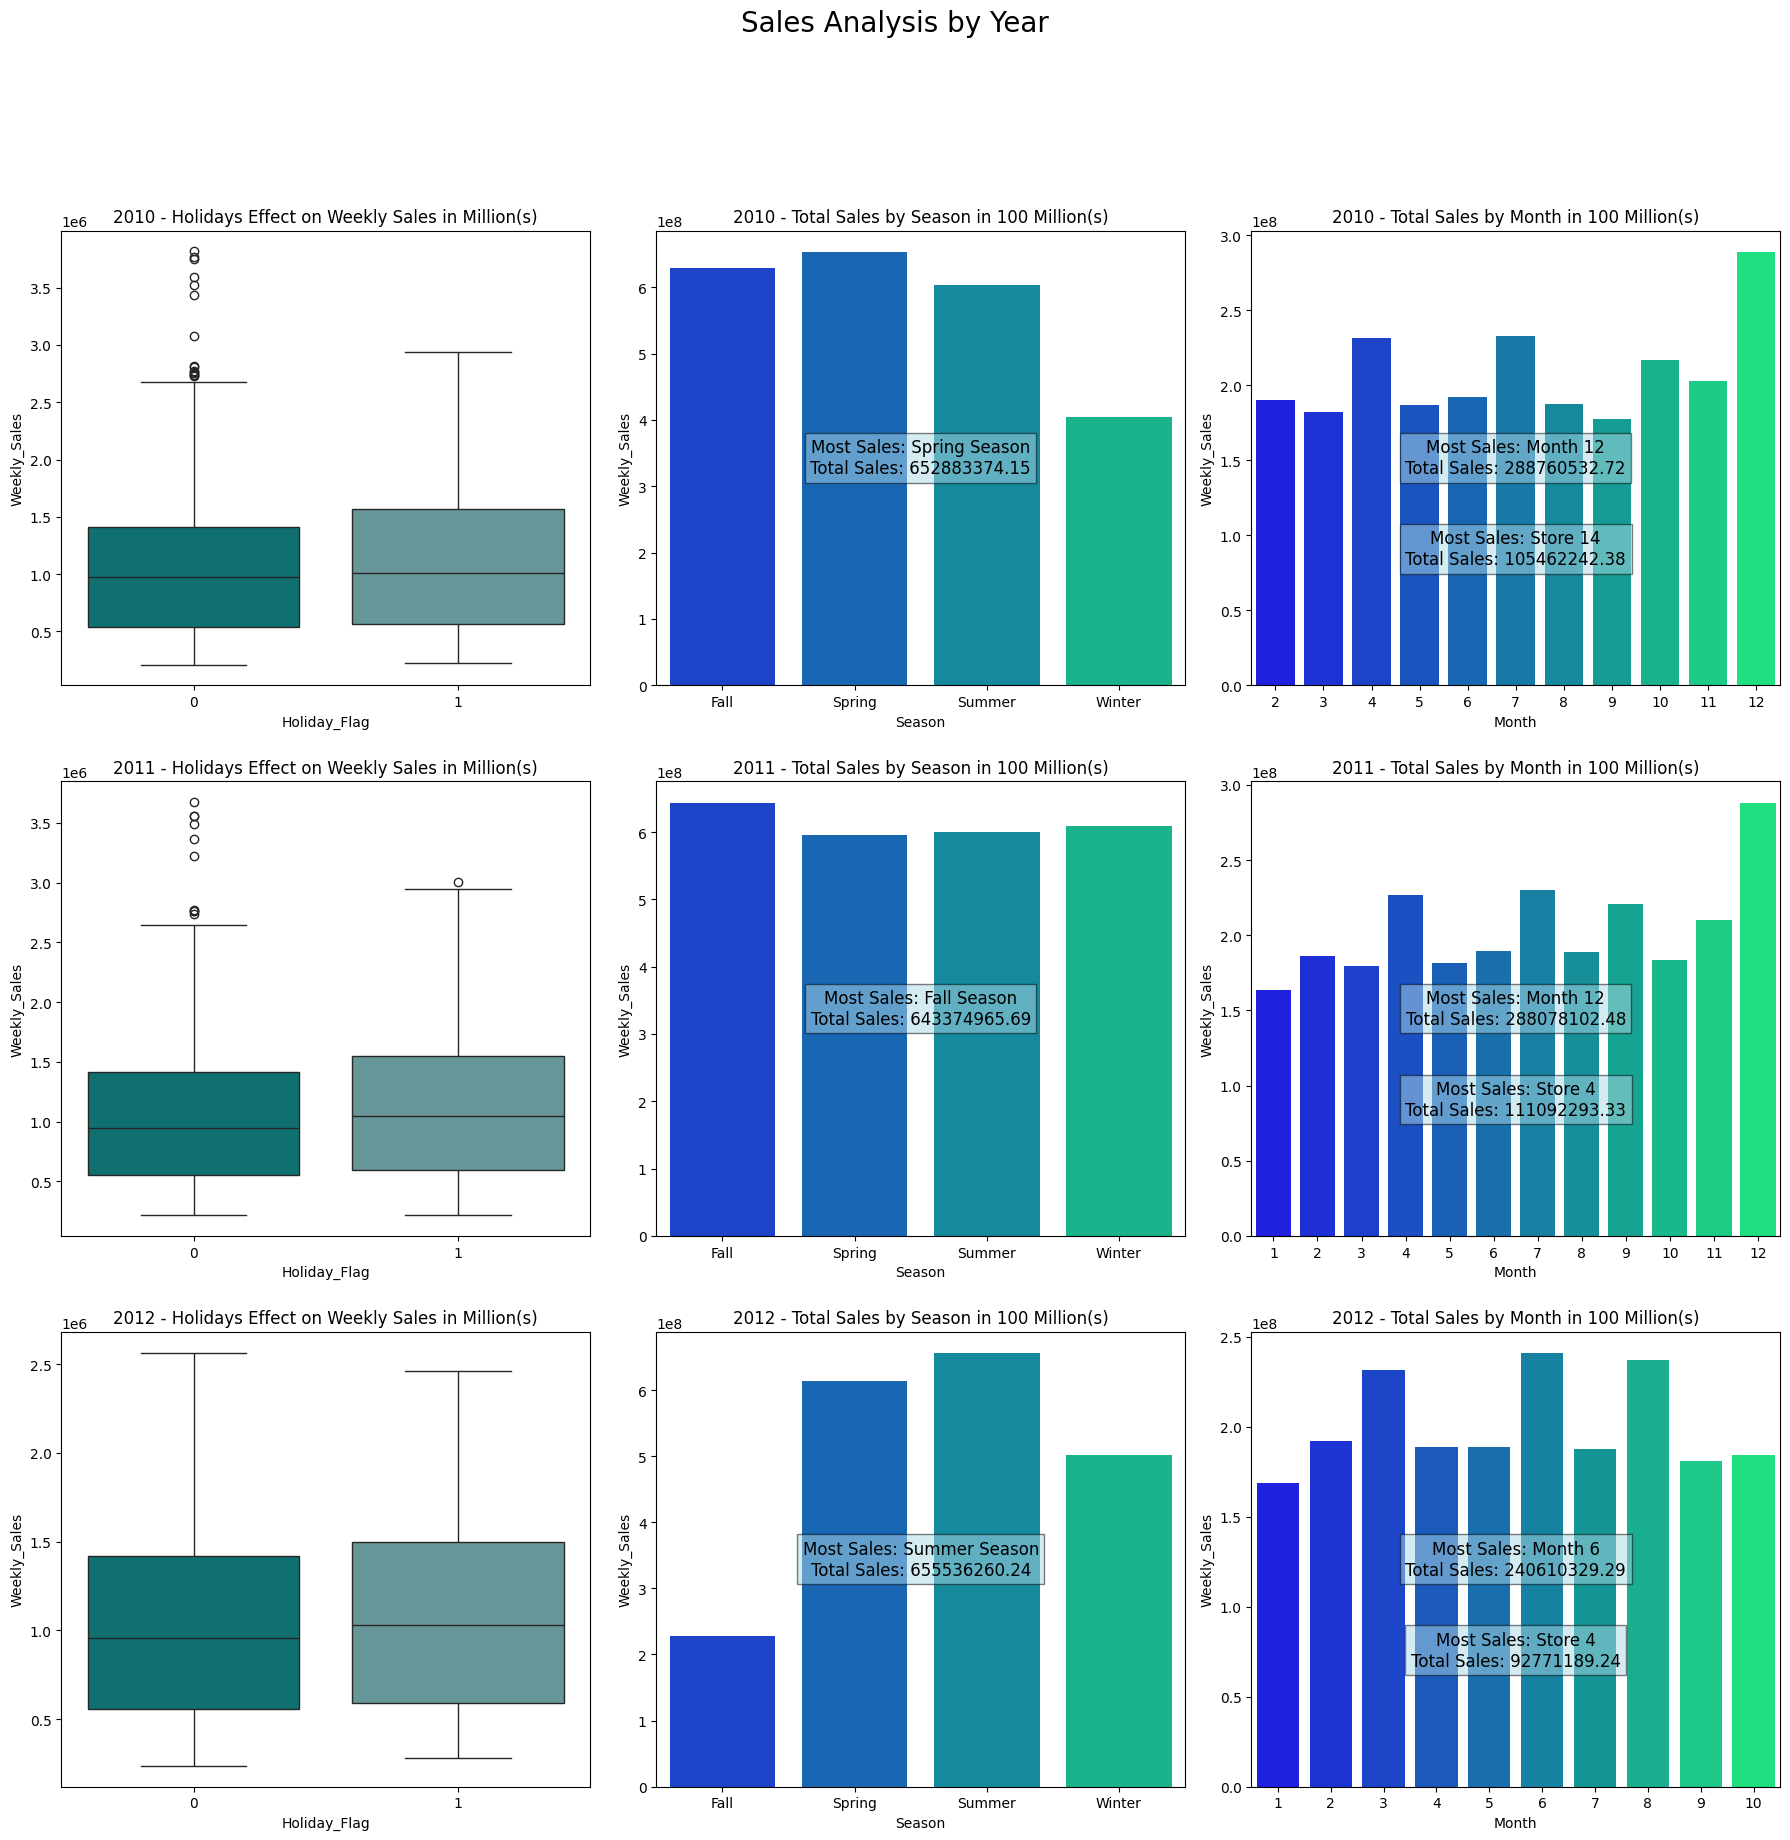

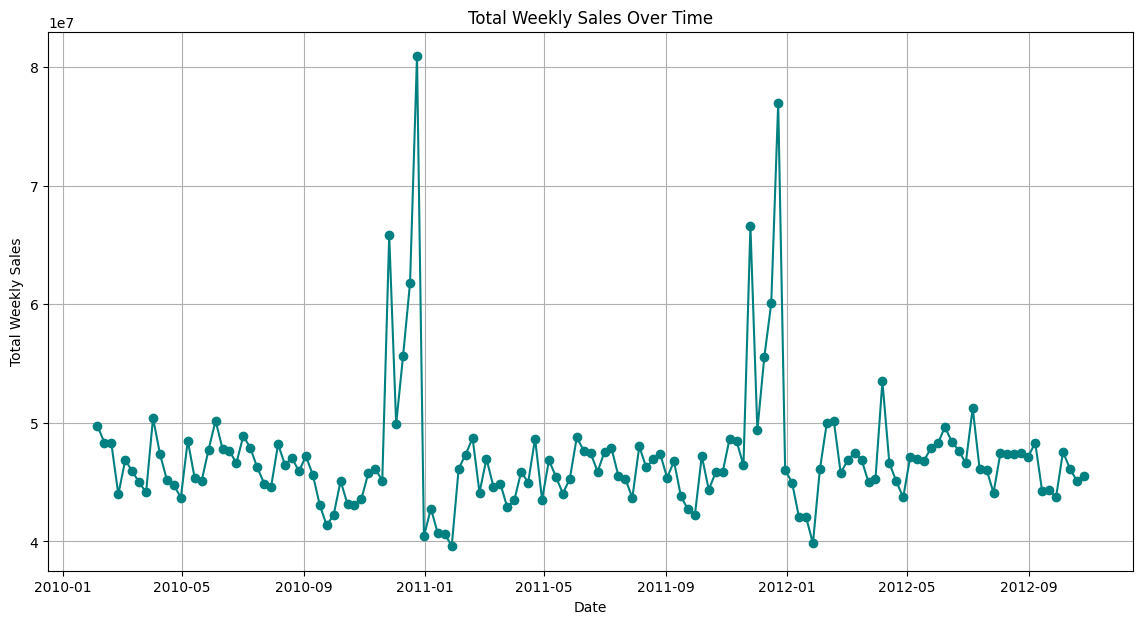

Year 2010 Analysis:
1. Holidays affect weekly sales, with the average sales during holidays being 1112358.88 compared to 1054879.56 on non-holidays.
2. The season with the most sales is Spring with total sales of 652883374.15.
3. The month with the most sales is 12 with total sales of 288760532.72.
4. The store with the most sales is Store 14 with total sales of 105462242.38.


Year 2011 Analysis:
1. Holidays affect weekly sales, with the average sales during holidays being 1148530.48 compared to 1037715.06 on non-holidays.
2. The season with the most sales is Fall with total sales of 643374965.69.
3. The month with the most sales is 12 with total sales of 288078102.48.
4. The store with the most sales is Store 4 with total sales of 111092293.33.


Year 2012 Analysis:
1. Holidays affect weekly sales, with the average sales during holidays being 1092660.75 compared to 1030782.33 on non-holidays.
2. The season with the most sales is Summer with total sales of 655536260.24.
3. The month w

In [15]:
# Extract additional time-related features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day_name()

# Function to categorize seasons based on the specific date ranges
def get_season(date):
    # Define date ranges for each season
    if pd.Timestamp(date.year, 3, 19) <= date <= pd.Timestamp(date.year, 6, 20):
        return 'Spring'
    elif pd.Timestamp(date.year, 6, 21) <= date <= pd.Timestamp(date.year, 9, 21):
        return 'Summer'
    elif pd.Timestamp(date.year, 9, 22) <= date <= pd.Timestamp(date.year, 12, 20):
        return 'Fall'
    else:
        return 'Winter'

# Apply get_season to each row in the DataFrame
df['Season'] = df['Date'].apply(get_season)

# Print out any dates categorized as 'Unknown'
unknown_dates = df[df['Season'].isna()]['Date'].tolist()
if unknown_dates:
    print("Dates categorized as Unknown:")
    for date in unknown_dates:
        print(date)
else:
    print("No dates categorized as Unknown.")

# Create a 3x3 grid for all visualizations
fig, axs = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Sales Analysis by Year', fontsize=20, y=1.02)

# Plotting functions for each year
def plot_yearly_data(year, ax, index):
    yearly_data = df[df['Year'] == year]

    # Holidays effect on weekly sales
    sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=yearly_data, hue='Holiday_Flag', palette=['#008080', '#5f9ea0'], ax=ax[index][0])
    ax[index][0].set_title(f'{year} - Holidays Effect on Weekly Sales in Million(s)')
    ax[index][0].set_xlabel('Holiday_Flag')
    if ax[index][0].legend_ is not None:
        ax[index][0].legend_.remove()

    # Sales by Season
    season_sales = yearly_data.groupby('Season')['Weekly_Sales'].sum().reset_index()
    max_season = season_sales.loc[season_sales['Weekly_Sales'].idxmax()]
    sns.barplot(x='Season', y='Weekly_Sales', data=season_sales, hue='Season', palette='winter', ax=ax[index][1])
    ax[index][1].set_title(f'{year} - Total Sales by Season in 100 Million(s)')
    if ax[index][1].legend_ is not None:
        ax[index][1].legend_.remove()
    ax[index][1].text(0.5, 0.5, f'Most Sales: {max_season["Season"]} Season\nTotal Sales: {max_season["Weekly_Sales"]:.2f}', ha='center', va='center', transform=ax[index][1].transAxes, fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

    # Sales by Month
    month_sales = yearly_data.groupby('Month')['Weekly_Sales'].sum().reset_index()
    max_month = month_sales.loc[month_sales['Weekly_Sales'].idxmax()]
    sns.barplot(x='Month', y='Weekly_Sales', data=month_sales, hue='Month', palette='winter', ax=ax[index][2])
    ax[index][2].set_title(f'{year} - Total Sales by Month in 100 Million(s)')
    if ax[index][2].legend_ is not None:
        ax[index][2].legend_.remove()
    ax[index][2].text(0.5, 0.5, f'Most Sales: Month {int(max_month["Month"])}\nTotal Sales: {max_month["Weekly_Sales"]:.2f}', ha='center', va='center', transform=ax[index][2].transAxes, fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

    # Store with most sales
    store_sales = yearly_data.groupby('Store')['Weekly_Sales'].sum().reset_index()
    max_store = store_sales.loc[store_sales['Weekly_Sales'].idxmax()]
    ax[index][2].text(0.5, 0.3, f'Most Sales: Store {int(max_store["Store"])}\nTotal Sales: {max_store["Weekly_Sales"]:.2f}', ha='center', va='center', transform=ax[index][2].transAxes, fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

# Plot for each year in different rows
plot_yearly_data(2010, axs, 0)
plot_yearly_data(2011, axs, 1)
plot_yearly_data(2012, axs, 2)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Plot the aggregated weekly sales
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], marker='o', color='#008080')
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.grid(True)
plt.show()

# Analysis in sentence form for each year
for year in [2010, 2011, 2012]:
    yearly_data = df[df['Year'] == year]

    holiday_effect = yearly_data.groupby('Holiday_Flag')['Weekly_Sales'].mean()
    season_sales = yearly_data.groupby('Season')['Weekly_Sales'].sum().sort_values(ascending=False)
    month_sales = yearly_data.groupby('Month')['Weekly_Sales'].sum().sort_values(ascending=False)

    store_sales = yearly_data.groupby('Store')['Weekly_Sales'].sum().reset_index()
    max_store = store_sales.loc[store_sales['Weekly_Sales'].idxmax()]

    print(f"Year {year} Analysis:")
    print(f"1. Holidays affect weekly sales, with the average sales during holidays being {holiday_effect[1]:.2f} compared to {holiday_effect[0]:.2f} on non-holidays.")
    print(f"2. The season with the most sales is {season_sales.index[0]} with total sales of {season_sales.iloc[0]:.2f}.")
    print(f"3. The month with the most sales is {month_sales.index[0]} with total sales of {month_sales.iloc[0]:.2f}.")
    print(f"4. The store with the most sales is Store {int(max_store['Store'])} with total sales of {max_store['Weekly_Sales']:.2f}.")
    print("\n")


Summary:

---

Despite the absence of January 2010 and December 2012 data:

There is an overall observed effect of holidays on weekly sales. In broader trends, Spring, Fall and Summer are the peak seasons. There are historical sales in December 2010 and 2011; the absence of December 2012 in the dataset should not negatively impact the general understanding of seasonal sales peak during this month. Store 14 in 2010 and Store 4 in 2011 and 2012 is a valid observation despite missing months. It helps to identify high performing stores for either focusing resources or identifying success factors at the stores.

####**Histograms and Plots:**

Holiday_flag (1 and 0), and derived time variables (Year, Month, Day, WeekOfYear).

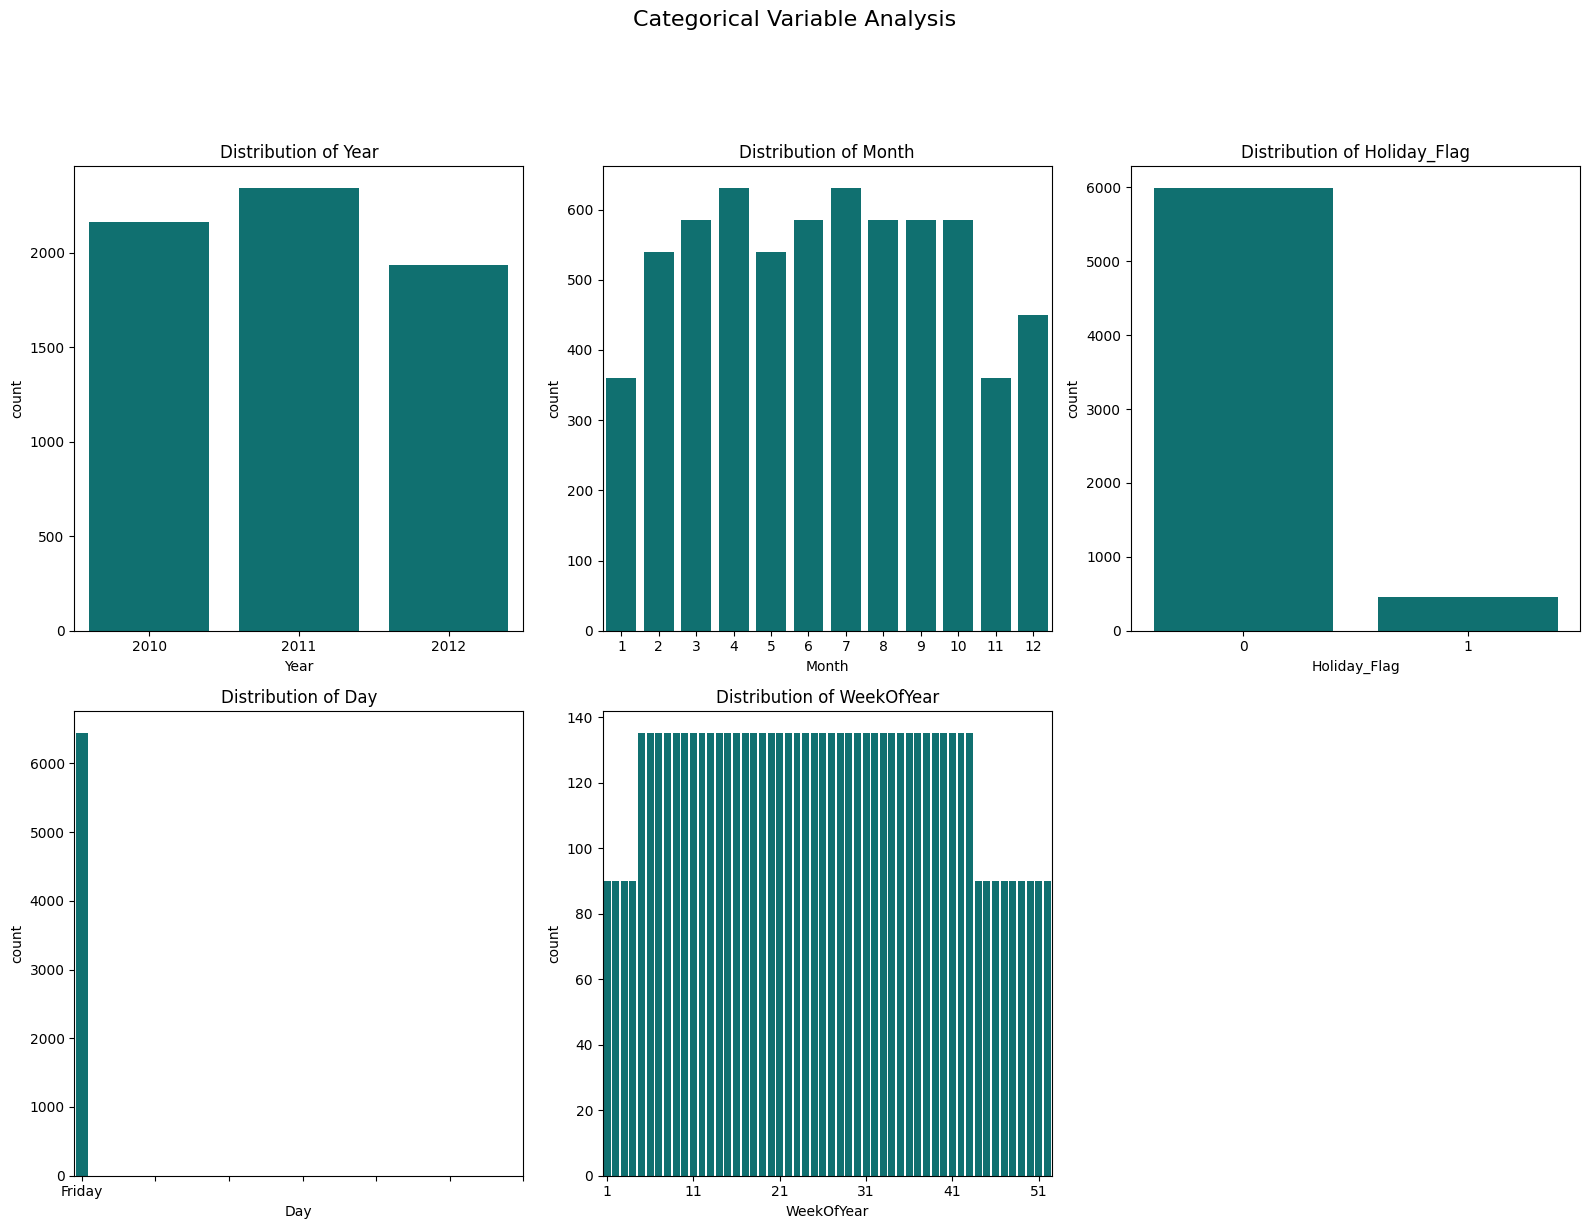

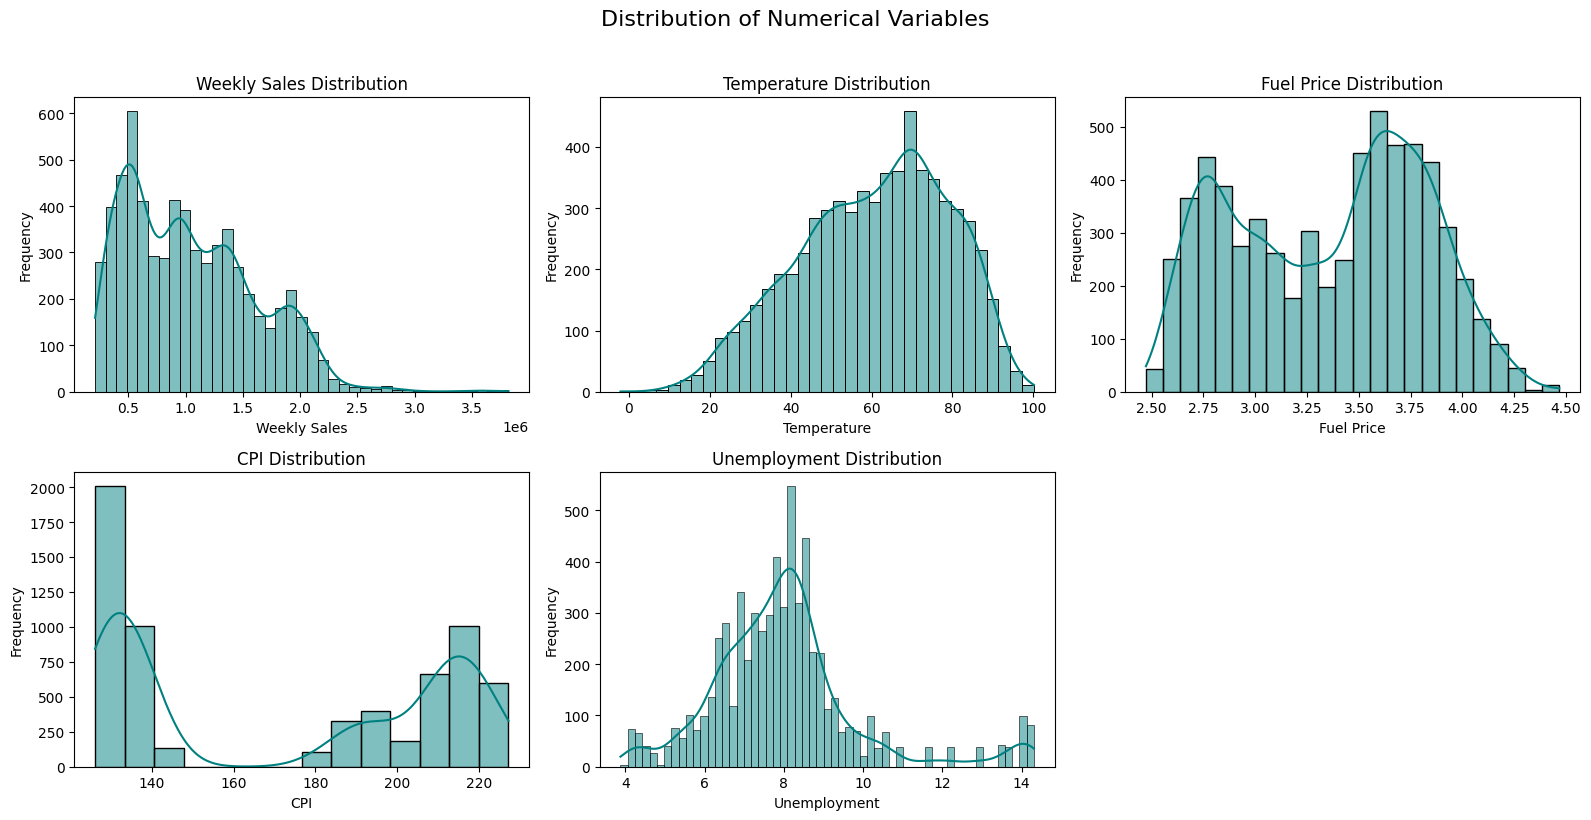

In [16]:
# Categorical Variable Analysis
plt.figure(figsize=(16, 12))

# Centered and Larger Title
plt.suptitle('Categorical Variable Analysis', fontsize=16, y=1.02)

# First Line: Distribution of Year, Month, and Holiday_Flag
plt.subplot(2, 3, 1)
sns.countplot(x='Year', data=df, color='teal')
plt.title('Distribution of Year')

plt.subplot(2, 3, 2)
sns.countplot(x='Month', data=df, color='teal')
plt.title('Distribution of Month')

plt.subplot(2, 3, 3)
sns.countplot(x='Holiday_Flag', data=df, color='teal')
plt.title('Distribution of Holiday_Flag')

# Second Line: Distribution of Day and WeekOfYear
plt.subplot(2, 3, 4)
sns.countplot(x='Day', data=df, color='teal')
plt.title('Distribution of Day')
plt.xticks(range(0, 32, 5))  # Show every 5th tick for Day

plt.subplot(2, 3, 5)
sns.countplot(x='WeekOfYear', data=df, color='teal')
plt.title('Distribution of WeekOfYear')
plt.xticks(range(0, 53, 10))  # Show every 10th tick for WeekOfYear

# Adjust layout for the first part
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Histograms (combine all in one figure)
plt.figure(figsize=(16, 8))

# Second Plots Title
plt.suptitle('Distribution of Numerical Variables', fontsize=16, y=1.02)

plt.subplot(2, 3, 1)
sns.histplot(df['Weekly_Sales'], kde=True, color='teal')
plt.title('Weekly Sales Distribution')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
sns.histplot(df['Temperature'], kde=True, color='teal')
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
sns.histplot(df['Fuel_Price'], kde=True, color='teal')
plt.title('Fuel Price Distribution')
plt.xlabel('Fuel Price')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
sns.histplot(df['CPI'], kde=True, color='teal')
plt.title('CPI Distribution')
plt.xlabel('CPI')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
sns.histplot(df['Unemployment'], kde=True, color='teal')
plt.title('Unemployment Distribution')
plt.xlabel('Unemployment')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()


Insight into dataset's temporal (time), economic and seasonal dynamics:

---

2011 appears to have more data points and could be due to information gathered covers 2010-02-05 to 2012-11-01. April and July indicates higher peaks. Weekly sales peak around 0.5 million with a right tail suggesting occasional high sales figures (special events or promotions or outliers). There are more occurrences at lower temperatures in the dataset (lower than 70). Fuel price has two peaks which suggest a possible change in price over time.  CPI has a peak at ~75 and at ~218 showing varying consumer price index levels; it's at 0 around 145-175 suggesting stability. Unemployment peaks at around 9 with lower values surrounding suggesting variation in the rates.

Friday is the only day in the plot. This could be that sales data is recorded weekly on Fridays and we will disregard it/drop it as there's no insightful information.

In [17]:
print(df.columns)

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day',
       'WeekOfYear', 'Week', 'Season'],
      dtype='object')


###Feature Selection

In [18]:
def drop_unnecessary_columns(df):
    """Drop columns not needed for feature selection."""
    return df.drop(columns=['Day', 'Season', 'Week'])

def select_k_best(X, y, k=5):
    """Select top k features based on f_regression."""
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    selected_features = X.columns[selected_indices]
    print("Selected features from SelectKBest:", selected_features)
    print()
    return selected_features

def calculate_feature_variance(df, threshold=0.2):
    """Select features based on variance threshold."""
    variances = df.var()
    selected_features_variance = variances[variances >= threshold].index.tolist()
    print("Selected Features based on Variance Threshold:")
    print(selected_features_variance)
    print()
    return selected_features_variance

def random_forest_importances(X, y):
    """Get feature importances from Random Forest."""
    rf = RandomForestRegressor()
    rf.fit(X, y)
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Feature Importances from Random Forest:")
    print(feature_importances)
    print()
    return feature_importances

def anova_f_test(X, y):
    """Perform ANOVA F-test."""
    f_values, p_values = f_regression(X, y)
    anova_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'p-Value': p_values})
    anova_results = anova_results.sort_values(by='F-Value', ascending=False)
    print("ANOVA F-test Results:")
    print(anova_results)
    print()
    return anova_results

# Example usage
df_preprocessed = drop_unnecessary_columns(df)

# Separate features and target variable
X = df_preprocessed.drop(['Weekly_Sales', 'Date'], axis=1)
y = df_preprocessed['Weekly_Sales']

# Apply feature selection methods
select_k_best(X, y)
calculate_feature_variance(X)
random_forest_importances(X, y)
anova_f_test(X, y)


Selected features from SelectKBest: Index(['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear'], dtype='object')

Selected Features based on Variance Threshold:
['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'WeekOfYear']

Feature Importances from Random Forest:
Store           0.669971
CPI             0.152629
Unemployment    0.100957
WeekOfYear      0.050345
Temperature     0.012257
Fuel_Price      0.008549
Month           0.002644
Holiday_Flag    0.001395
Year            0.001252
dtype: float64

ANOVA F-test Results:
        Feature     F-Value        p-Value
0         Store  815.022439  6.883078e-169
5  Unemployment   73.348421   1.344837e-17
7         Month   37.514784   9.607839e-10
8    WeekOfYear   35.624738   2.519662e-09
4           CPI   34.118717   5.438293e-09
2   Temperature   26.300448   3.007648e-07
1  Holiday_Flag    8.766881   3.078699e-03
6          Year    2.173377   1.404665e-01
3    Fuel_Price    0.576212   4.478287e-01



,Feature,F-Value,p-Value
0,Store,815.022439,6.883078e-169
5,Unemployment,73.348421,1.344837e-17
7,Month,37.514784,9.607839e-10
8,WeekOfYear,35.624738,2.519662e-09
4,CPI,34.118717,5.438293e-09
2,Temperature,26.300448,3.007648e-07
1,Holiday_Flag,8.766881,3.078699e-03
6,Year,2.173377,1.404665e-01
3,Fuel_Price,0.576212,4.478287e-01


Based on the collective selection tests, Store appears crucial for predicting as it's highest rated and highest F-Value 815.02. CPI, Unemployment, Month and WeekOfYear also appear to provide insight to predictive power.

###Data Preparation

In [19]:
def prepare_data(df, selected_features, target, test_size=0.2, random_state=42):
    """
    Prepares the data for modeling by selecting features, splitting into train/test sets,
    and scaling the features.
    Parameters:
    - df: DataFrame with the dataset
    - selected_features: List of features to use
    - target: The target variable name
    - test_size: Proportion of data to use for testing
    - random_state: Seed for random number generator
    Returns:
    - X_train_scaled: Scaled training features
    - X_test_scaled: Scaled testing features
    - y_train: Training target values
    - y_test: Testing target values
    """
    # Use only selected features
    X = df[selected_features]
    y = df[target]

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and test data
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform only X_train
    X_test_scaled = scaler.transform(X_test)        # Transform X_test using the same scaler

    # Print out to confirm
    print("Selected Features:")
    print(selected_features)
    print()
    print(f"Target: {target}")
    print()
    print("Data Preparation Completed:")
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")

    return X_train_scaled, X_test_scaled, y_train, y_test


selected_features = ['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear']
target = 'Weekly_Sales'
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(df, selected_features, target)


Selected Features:
['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear']

Target: Weekly_Sales

Data Preparation Completed:
Training set size: 5148 samples
Testing set size: 1287 samples


####Save cleaned features to .csv

In [20]:
# Combine scaled features and target into a DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=selected_features)
X_train_scaled_df[target] = y_train.values

# Save to CSV
X_train_scaled_df.to_csv('/content/Walmart_cleaned.csv', index=False)
print("Cleaned and scaled feature data with target saved to /content/Walmart_cleaned.csv")

Cleaned and scaled feature data with target saved to /content/Walmart_cleaned.csv


###Algorithms

In [21]:
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings

# Instantiate the regressors
lin_reg = LinearRegression()
rf_regressor = RandomForestRegressor(random_state=42)
gb_regressor = GradientBoostingRegressor(random_state=42)
svm_regressor = SVR()

# Split ratios
splits = {
    "60-40": 0.4,
    "70-30": 0.3,
    "80-20": 0.2
}

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Train and evaluate models
def train_and_evaluate_regressor(model, X_train_scaled, X_test_scaled, y_train, y_test):
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"{type(model).__name__}:")
    print(f"Train - MAE: {train_mae:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R^2: {train_r2:.4f}, MAPE: {train_mape:.2f}%")
    print(f"Test  - MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R^2: {test_r2:.4f}, MAPE: {test_mape:.2f}%")
    print()

# Train and evaluate each model for each split ratio
for name, test_size in splits.items():
    print(f"Split Ratio: {name}")

    # Split the data
    X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Train and evaluate each regressor
    train_and_evaluate_regressor(lin_reg, X_train_scaled, X_test_scaled, y_train, y_test)
    train_and_evaluate_regressor(rf_regressor, X_train_scaled, X_test_scaled, y_train, y_test)
    train_and_evaluate_regressor(gb_regressor, X_train_scaled, X_test_scaled, y_train, y_test)
    train_and_evaluate_regressor(svm_regressor, X_train_scaled, X_test_scaled, y_train, y_test)


Split Ratio: 60-40
LinearRegression:
Train - MAE: 428453.4298, MSE: 272162416603.8847, RMSE: 521691.8790, R^2: 0.1464, MAPE: 60.51%
Test  - MAE: 430301.1727, MSE: 269393032583.8166, RMSE: 519030.8590, R^2: 0.1521, MAPE: 61.33%

RandomForestRegressor:
Train - MAE: 23455.1020, MSE: 1952802146.4582, RMSE: 44190.5210, R^2: 0.9939, MAPE: 2.19%
Test  - MAE: 68274.2441, MSE: 16571297271.7741, RMSE: 128729.5509, R^2: 0.9478, MAPE: 6.20%

GradientBoostingRegressor:
Train - MAE: 125150.8813, MSE: 27750608267.1907, RMSE: 166585.1382, R^2: 0.9130, MAPE: 16.64%
Test  - MAE: 128529.3029, MSE: 29498181484.6581, RMSE: 171750.3464, R^2: 0.9072, MAPE: 17.22%

SVR:
Train - MAE: 459743.7810, MSE: 326449833333.6098, RMSE: 571357.8855, R^2: -0.0239, MAPE: 59.89%
Test  - MAE: 469864.8555, MSE: 328733280582.2000, RMSE: 573352.6668, R^2: -0.0347, MAPE: 60.88%

Split Ratio: 70-30
LinearRegression:
Train - MAE: 428991.8504, MSE: 271573943572.4086, RMSE: 521127.5694, R^2: 0.1455, MAPE: 60.74%
Test  - MAE: 430098.

<table border="1" cellspacing="0" cellpadding="5">
  <tr>
    <th>Metric</th>
    <th colspan="2">LinearRegression<br>80/20</th>
    <th colspan="2">RandomForestRegression<br>80/20</th>
    <th colspan="2">GradientBoostingRegressor<br>80/20</th>
    <th colspan="2">SupportVectorRegressor<br>70/30</th>
  </tr>
  <tr>
    <th></th>
    <th>Train</th>
    <th>Test</th>
    <th>Train</th>
    <th>Test</th>
    <th>Train</th>
    <th>Test</th>
    <th>Train</th>
    <th>Test</th>
  </tr>
  <tr>
    <td>MAE</td>
    <td>428602.89</td>
    <td>432594.98</td>
    <td>21912.37</td>
    <td>62022.51</td>
    <td>120133.89</td>
    <td>122332.01</td>
    <td>460935.91</td>
    <td>470357.14</td>
  </tr>
  <tr>
    <td>MSE</td>
    <td>270646146103.93</td>
    <td>272049348139.45</td>
    <td>1605085801.21</td>
    <td>13020256696.91</td>
    <td>25802933621.84</td>
    <td>26960669928.89</td>
    <td>325316958048.13</td>
    <td>330848141076.85</td>
  </tr>
  <tr>
    <td>RMSE</td>
    <td>520236.63</td>
    <td>521583.50</td>
    <td>40063.52</td>
    <td>114106.34</td>
    <td>160632.92</td>
    <td>164197.05</td>
    <td>570365.64</td>
    <td>575194.00</td>
  </tr>
  <tr>
    <td>R²</td>
    <td>0.1476</td>
    <td>0.1555</td>
    <td>0.9949</td>
    <td>0.9596</td>
    <td>0.9187</td>
    <td>0.9163</td>
    <td>-0.0236</td>
    <td>-0.0348</td>
  </tr>
  <tr>
    <td>MAPE</td>
    <td>60.63% </td>
    <td>62.18%</td>
    <td>2.04%</td>
    <td>5.72%</td>
    <td>15.51%</td>
    <td>15.89%</td>
    <td>60.15%</td>
    <td>61.02%</td>
  </tr>
</table>


*Linear Regression:*

Performs best at 70/30 split with R^2 value highest at 0.1563 and a relatively lower MAPE (60.97%). It's not a great performing model but it is the best split that provides some balance between training and testing data.

*Random Forest Regressor:*

Performs best at 80/20 split with R^2 at 0.9596 and lowest MAPE (5.72%) on the test set. At this split, the model appears to learn and generalize better with improved accuracy and lower prediction error.

*Gradient Boosting Regressor:*

Performs best at 80/20 split with R^2 at 0.9163 and loest MAPE (15.89%) on the test set. The larger training set seems to capture more complex patterns resulting in better performance.

*Support Vector Regressor (SVR):*

Performs best at 70/30 split with MAPE at 61.02% but a poor negative R^2.<br><br>

As we are looking for high R^2 (to explain large portion of variance in the target value, and closer to 1 suggets a better fit) and a low MAPE (lower reflects better accuracy in prediction), we will proceed to tune only the best two: Random Forest Regressor and Gradient Boosting Regressor.


###Hyperparameter Tuning


####Default Parameters

In [22]:
def get_default_rf_params():
    model = RandomForestRegressor(random_state=42)
    default_params = model.get_params()
    print("\nDefault Hyperparameters for RandomForestRegressor:")
    for param, value in default_params.items():
        print(f"{param}: {value}")
    return default_params

default_rf_params = get_default_rf_params()

def get_default_gb_params():
    model = GradientBoostingRegressor()
    default_params = model.get_params()
    print("\nDefault Hyperparameters for GradientBoostingRegressor:")
    for param, value in default_params.items():
        print(f"{param}: {value}")
    return default_params

default_gb_params = get_default_gb_params()


Default Hyperparameters for RandomForestRegressor:
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False

Default Hyperparameters for GradientBoostingRegressor:
alpha: 0.9
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: squared_error
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_iter_no_change: None
random_state: None
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False


####Best Parameter Grid Search for Random Forest Regressor

In [23]:
from sklearn.model_selection import GridSearchCV

def tune_random_forest(X_train_scaled, y_train):
    # Define parameter grid for RandomForestRegressor
    param_grid = {
        'n_estimators': [50, 100], # Number of trees in forest
        'max_depth': [None, 10, 20], # Max depth of trees
        'min_samples_split': [2, 5], # Min number of samples required
        'min_samples_leaf': [1, 2, 4], # Min number of samples required
        'max_features': ['sqrt', 'log2']         # Number of features to consider when looking for the best split
    }

    # Initialize model
    model = RandomForestRegressor(random_state=42)

    # Create GridSearchCV instance
    grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, error_score='raise')

    # Fit model to perform search
    grid_search.fit(X_train_scaled, y_train)

    # Get best hyperparameters from search
    best_params = grid_search.best_params_

    # Print the best hyperparameters
    print("\nBest Hyperparameters for RandomForestRegressor:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    return best_params

# Calls prepare_data function ensured scaled ariables are defined w/appropriate scaled data Just so I can ensure it's using it
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(df, selected_features, target)

# Call the function to tune RandomForestRegressor
best_rf_params = tune_random_forest(X_train_scaled, y_train)


Selected Features:
['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear']

Target: Weekly_Sales

Data Preparation Completed:
Training set size: 5148 samples
Testing set size: 1287 samples

Best Hyperparameters for RandomForestRegressor:
max_depth: 20
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 100


####Best Parameter Grid Search for Gradient Boosting Regressor

In [24]:
def tune_gradient_boosting(X_train_scaled, y_train):
    # Parameter grid for GradientBoostingRegressor
    param_grid = {
        'n_estimators': [100, 200], # Number of boosting stages to be run
        'learning_rate': [0.01, 0.1], # Step size for each iteration
        'max_depth': [3, 5], # Maximum depth of the individual trees
        'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2], # Minimum number of samples required to be at a leaf node
    }

    # Initialize model
    model = GradientBoostingRegressor(random_state=42)

    # Create GridSearchCV instance
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, error_score='raise')

    # Fit model to perform search
    grid_search.fit(X_train_scaled, y_train)

    # Get best hyperparameters from search
    best_params = grid_search.best_params_

    # Print the best hyperparameters
    print("\nBest Hyperparameters for GradientBoostingRegressor:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    return best_params

# Call the function to tune GradientBoostingRegressor
best_gb_params = tune_gradient_boosting(X_train_scaled, y_train)



Best Hyperparameters for GradientBoostingRegressor:
learning_rate: 0.1
max_depth: 5
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 200


####Evaluate

In [25]:
def evaluate_regression_model(y_true, y_pred):
    """
    Evaluate regression model performance.
    Args:
    - y_true (pd.Series or np.array): True target values.
    - y_pred (pd.Series or np.array): Predicted values.
    Returns:
    - tuple: MAE, MSE, RMSE, R^2, and MAPE.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, mse, rmse, r2, mape

def train_predict_evaluate_regression(X, y, test_size, best_rf_params, best_gb_params):
    """
    Train, predict, and evaluate Random Forest and Gradient Boosting regressors.
    Parameters:
    - X (pd.DataFrame): Feature data.
    - y (pd.Series): Target data.
    - test_size (float): Proportion of data to be used as test set.
    - best_rf_params (dict): Best hyperparameters for Random Forest.
    - best_gb_params (dict): Best hyperparameters for Gradient Boosting.
    Returns:
    - tuple: (trained_rf_model, trained_gb_model, metrics_dict)
    """
    # SPLIT the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # SCALE the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models with best hyperparameters
    rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
    gb_model = GradientBoostingRegressor(**best_gb_params, random_state=42)

    # TRAIN models
    rf_model.fit(X_train_scaled, y_train)
    gb_model.fit(X_train_scaled, y_train)

    # PREDICT
    rf_train_preds = rf_model.predict(X_train_scaled)
    rf_test_preds = rf_model.predict(X_test_scaled)
    gb_train_preds = gb_model.predict(X_train_scaled)
    gb_test_preds = gb_model.predict(X_test_scaled)

    # EVALUATE
    metrics_dict = {
        'Random Forest': {
            'train': evaluate_regression_model(y_train, rf_train_preds),
            'test': evaluate_regression_model(y_test, rf_test_preds)
        },
        'Gradient Boosting': {
            'train': evaluate_regression_model(y_train, gb_train_preds),
            'test': evaluate_regression_model(y_test, gb_test_preds)
        }
    }

    # Print results
    print(f"\nEvaluation for Random Forest Regressor:\n")
    print(f"Test Size: {test_size}")
    print(f"Train - MAE: {metrics_dict['Random Forest']['train'][0]:.4f}, MSE: {metrics_dict['Random Forest']['train'][1]:.4f}, RMSE: {metrics_dict['Random Forest']['train'][2]:.4f}, R^2: {metrics_dict['Random Forest']['train'][3]:.4f}, MAPE: {metrics_dict['Random Forest']['train'][4]:.2f}%")
    print(f"Test  - MAE: {metrics_dict['Random Forest']['test'][0]:.4f}, MSE: {metrics_dict['Random Forest']['test'][1]:.4f}, RMSE: {metrics_dict['Random Forest']['test'][2]:.4f}, R^2: {metrics_dict['Random Forest']['test'][3]:.4f}, MAPE: {metrics_dict['Random Forest']['test'][4]:.2f}%")

    print(f"\nEvaluation for Gradient Boosting Regressor:\n")
    print(f"Test Size: {test_size}")
    print(f"Train - MAE: {metrics_dict['Gradient Boosting']['train'][0]:.4f}, MSE: {metrics_dict['Gradient Boosting']['train'][1]:.4f}, RMSE: {metrics_dict['Gradient Boosting']['train'][2]:.4f}, R^2: {metrics_dict['Gradient Boosting']['train'][3]:.4f}, MAPE: {metrics_dict['Gradient Boosting']['train'][4]:.2f}%")
    print(f"Test  - MAE: {metrics_dict['Gradient Boosting']['test'][0]:.4f}, MSE: {metrics_dict['Gradient Boosting']['test'][1]:.4f}, RMSE: {metrics_dict['Gradient Boosting']['test'][2]:.4f}, R^2: {metrics_dict['Gradient Boosting']['test'][3]:.4f}, MAPE: {metrics_dict['Gradient Boosting']['test'][4]:.2f}%")

    # Return trained models and metrics
    return rf_model, gb_model, metrics_dict

# Call the function for all splits
rf_model_60, gb_model_60, metrics_60 = train_predict_evaluate_regression(X, y, test_size=0.4, best_rf_params=best_rf_params, best_gb_params=best_gb_params)  # 60:40 split
rf_model_70, gb_model_70, metrics_70 = train_predict_evaluate_regression(X, y, test_size=0.3, best_rf_params=best_rf_params, best_gb_params=best_gb_params)  # 70:30 split
rf_model_80, gb_model_80, metrics_80 = train_predict_evaluate_regression(X, y, test_size=0.2, best_rf_params=best_rf_params, best_gb_params=best_gb_params)  # 80:20 split



Evaluation for Random Forest Regressor:

Test Size: 0.4
Train - MAE: 36427.0547, MSE: 3502908460.2526, RMSE: 59185.3737, R^2: 0.9890, MAPE: 4.25%
Test  - MAE: 93305.1179, MSE: 22332093273.9018, RMSE: 149439.2628, R^2: 0.9297, MAPE: 10.64%

Evaluation for Gradient Boosting Regressor:

Test Size: 0.4
Train - MAE: 33997.9664, MSE: 2360744536.0933, RMSE: 48587.4936, R^2: 0.9926, MAPE: 3.82%
Test  - MAE: 56146.5126, MSE: 8711913101.1480, RMSE: 93337.6296, R^2: 0.9726, MAPE: 5.94%

Evaluation for Random Forest Regressor:

Test Size: 0.3
Train - MAE: 34678.7181, MSE: 3122777581.8815, RMSE: 55881.8180, R^2: 0.9902, MAPE: 3.98%
Test  - MAE: 86418.8580, MSE: 20477910527.7603, RMSE: 143101.0501, R^2: 0.9360, MAPE: 9.56%

Evaluation for Gradient Boosting Regressor:

Test Size: 0.3
Train - MAE: 36116.1216, MSE: 2684402341.0511, RMSE: 51811.2183, R^2: 0.9916, MAPE: 4.07%
Test  - MAE: 54905.1675, MSE: 7950869692.4501, RMSE: 89167.6494, R^2: 0.9751, MAPE: 5.78%

Evaluation for Random Forest Regressor

| Metric           | Test Size | Random Forest Regressor (Train) | Random Forest Regressor (Test) | Gradient Boosting Regressor (Train) | Gradient Boosting Regressor (Test) |
|------------------|-----------|---------------------------------|-------------------------------|--------------------------------------|-----------------------------------|
| **MAE**          | 0.4       | 36,427.05                        | 93,305.12                     | 33,997.97                           | 56,146.51                         |
|                  | 0.3       | 34,678.72                        | 86,418.86                     | 36,116.12                           | 54,905.17                         |
|                  | 0.2       | 33,075.91                        | 84,772.85                     | 36,937.26                           | 54,935.57                         |
| **MSE**          | 0.4       | 3,502,908,460.25                 | 22,332,093,273.90             | 2,360,744,536.09                    | 8,711,913,101.15                  |
|                  | 0.3       | 3,122,777,581.88                 | 20,477,910,527.76             | 2,684,402,341.05                    | 7,950,869,692.45                  |
|                  | 0.2       | 2,878,654,964.96                 | 20,274,087,358.62             | 2,786,744,726.28                    | 8,078,968,022.36                  |
| **RMSE**         | 0.4       | 59,185.37                        | 149,439.26                    | 48,587.49                           | 93,337.63                         |
|                  | 0.3       | 55,881.82                        | 143,101.05                    | 51,811.22                           | 89,167.65                         |
|                  | 0.2       | 53,653.10                        | 142,387.10                    | 52,789.63                           | 89,883.08                         |
| **R²**           | 0.4       | 0.9890                           | 0.9297                        | 0.9926                               | 0.9726                            |
|                  | 0.3       | 0.9902                           | 0.9360                        | 0.9916                               | 0.9751                            |
|                  | 0.2       | 0.9909                           | 0.9371                        | 0.9912                               | 0.9749                            |
| **MAPE**         | 0.4       | 4.25%                            | 10.64%                        | 3.82%                                | 5.94%                             |
|                  | 0.3       | 3.98%                            | 9.56%                         | 4.07%                                | 5.78%                             |
|                  | 0.2       | 3.76%                            | 9.30%                         | 4.14%                                | 5.86%                             |


*Random Forest Regressor:*

Has strong performance. The highest R^2 on the 80/20 split is at 0.9371 with the MAPE at 9.30%.

*Gradient Boosting Regressor:*

Performs best at the 70/30 split, with an R^2 of 0.9751 and a MAPE at 5.78%. This indicates that it is the better model with overall predictive performance.

The Gradient Boosting Regressor is the best model here. It explains ~97.51% of the variance in the target variable-a high level of accuracy in predicting the target values. The average error in this model predictions are within + or - 5.78% of the actual values.

Even though we have an incomplete set of historical data, this model has the ability to generalize the data that is available in order to gain insights into potential markdown strategies. It will assist in the crucial decision making about promotional planning.


####Cross-validation of Tuned Gradient Boosting Regressor at 70/30 split

In [26]:
def cross_validate_model(model, X, y, cv=5):
    """
    Perform cross-validation on the provided model.
    Args:
    - model (sklearn model): The model to evaluate.
    - X (pd.DataFrame): Feature data.
    - y (pd.Series): Target data.
    - cv (int): Number of cross-validation folds.
    Returns:
    - dict: Cross-validation results with mean and standard deviation.
    """
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')

    # Convert negative MAE to positive and calculate mean and standard deviation
    mean_score = -scores.mean()
    std_score = scores.std()

    return {
        'mean_MAE': mean_score,
        'std_MAE': std_score
    }

# Perform cross-validation on the saved Gradient Boosting Regressor model
cv_results = cross_validate_model(gb_model_70, X, y, cv=5)

# Print results
print(f"Cross-Validation Results for Gradient Boosting Regressor (70/30 split):")
print(f"Mean MAE: {cv_results['mean_MAE']:.4f}")
print(f"Standard Deviation of MAE: {cv_results['std_MAE']:.4f}")


Cross-Validation Results for Gradient Boosting Regressor (70/30 split):
Mean MAE: 509162.2072
Standard Deviation of MAE: 140885.9584


The Gradient Boosting Regressor at the 70/30 split shows on average the predictions are off by ~509,162.21 units (typical prediction error across different folds). The high standard deviation (140,885.96) suggests significant variability in model performance across different folds. This  may indicate the performance may be less consistent when applied to different sections of the data.

####Further Tune Using RandomizedSearchCV for 70/30 Split

In [27]:
# Parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

def train_randomized_search(X, y, param_distributions, test_size=0.3, cv=5):
    """
    Train Gradient Boosting Regressor using RandomizedSearchCV and evaluate its performance.
    Parameters:
    - X (pd.DataFrame): Feature data.
    - y (pd.Series): Target data.
    - param_distributions (dict): Parameter grid for RandomizedSearchCV.
    - test_size (float): Proportion of data to be used as test set.
    - cv (int): Number of cross-validation folds.
    Returns:
    - dict: Best model and evaluation metrics.
    """
    # SPLIT the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # SCALE the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=GradientBoostingRegressor(random_state=42),
        param_distributions=param_distributions,
        n_iter=50, # Number of parameter settings sampled
        cv=cv, # Number of folds for cross-validation
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Fit RandomizedSearchCV
    random_search.fit(X_train_scaled, y_train)

    # Get the best model
    best_gb_model = random_search.best_estimator_

    # PREDICT using the best model
    gb_train_preds = best_gb_model.predict(X_train_scaled)
    gb_test_preds = best_gb_model.predict(X_test_scaled)

    # EVALUATE the model
    metrics = {
        'train': evaluate_regression_model(y_train, gb_train_preds),
        'test': evaluate_regression_model(y_test, gb_test_preds)
    }

    # Print results
    print(f"\nBest parameters found: {random_search.best_params_}")
    print(f"Best score: {random_search.best_score_}")

    print(f"\nEvaluation for Gradient Boosting Regressor:\n")
    print(f"Test Size: {test_size}")
    print(f"Train - MAE: {metrics['train'][0]:.4f}, MSE: {metrics['train'][1]:.4f}, RMSE: {metrics['train'][2]:.4f}, R^2: {metrics['train'][3]:.4f}, MAPE: {metrics['train'][4]:.2f}%")
    print(f"Test  - MAE: {metrics['test'][0]:.4f}, MSE: {metrics['test'][1]:.4f}, RMSE: {metrics['test'][2]:.4f}, R^2: {metrics['test'][3]:.4f}, MAPE: {metrics['test'][4]:.2f}%")

    return best_gb_model, metrics

# Call the function for 70/30 split
best_gb_model_70, metrics_70 = train_randomized_search(X, y, param_distributions, test_size=0.3, cv=5)


Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters found: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.1}
Best score: 0.974961431432005

Evaluation for Gradient Boosting Regressor:

Test Size: 0.3
Train - MAE: 36465.4362, MSE: 2831936495.5949, RMSE: 53215.9421, R^2: 0.9911, MAPE: 4.10%
Test  - MAE: 54477.5199, MSE: 7790984221.2238, RMSE: 88266.5521, R^2: 0.9756, MAPE: 5.76%


After further tuning with RandomizedSearchCV, there is a slight improvement.

####Cross Validate

In [28]:
def cross_validate_optimized_model(model, X, y, cv=5):
    """
    Perform cross-validation on the optimized model.
    Args:
    - model (sklearn model): The optimized model to evaluate.
    - X (pd.DataFrame): Feature data.
    - y (pd.Series): Target data.
    - cv (int): Number of cross-validation folds.
    Returns:
    - dict: Cross-validation results with mean and standard deviation of MAE.
    """
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')

    # Convert negative MAE to positive and calculate mean and standard deviation
    mean_score = -scores.mean()
    std_score = scores.std()

    return {
        'mean_MAE': mean_score,
        'std_MAE': std_score
    }

# Call the function to cross-validate the best Gradient Boosting model from RandomizedSearchCV
cv_results_optimized = cross_validate_optimized_model(best_gb_model_70, X, y, cv=5)

# Print results
print(f"Cross-Validation Results for Optimized Gradient Boosting Regressor (70/30 split):")
print(f"Mean MAE: {cv_results_optimized['mean_MAE']:.4f}")
print(f"Standard Deviation of MAE: {cv_results_optimized['std_MAE']:.4f}")


Cross-Validation Results for Optimized Gradient Boosting Regressor (70/30 split):
Mean MAE: 505204.4670
Standard Deviation of MAE: 135873.5531


We will compare the numbers before and after the tuning with RandomizedSearchCV:

| Metric                 | Test Size | Gradient Boosting Regressor<br> (Train) Before | Gradient Boosting Regressor<br> (Test) Before | Gradient Boosting Regressor<br> (Train) After | Gradient Boosting Regressor<br> (Test) After |
|------------------------|-----------|---------------------------------------------|------------------------------------------|-------------------------------------------|-----------------------------------------|
| **MAE**                | 0.3       | 36,116.12                                  | 54,905.17                                | 36,465.44                                | 54,477.52                              |
| **MSE**                | 0.3       | 2,684,402,341.05                           | 7,950,869,692.45                        | 2,831,936,495.59                         | 7,790,984,221.22                       |
| **RMSE**               | 0.3       | 51,811.22                                  | 89,167.65                                | 53,215.94                                | 88,266.55                              |
| **R²**                 | 0.3       | 0.9916                                     | 0.9751                                   | 0.9911                                    | 0.9756                                 |
| **MAPE**               | 0.3       | 4.07%                                      | 5.78%                                    | 4.10%                                    | 5.76%                                  |
| **Mean MAE (CV)**      | 0.3       | 509,162.21                                 | -                                        | 505,204.47                                | -                                       |
| **Std MAE (CV)**       | 0.3       | 140,885.96                                 | -                                        | 135,873.55                                | -                                       |


After further tuning with RandomizedSearchCV, there is a slight improvement. The MEAN, MAE and the Standard Deviation has decreased slightly. The R^2 is now at 0.9756 (minimally higher), and MAPE at 5.76% (minimally lower).

The Gradient Boosting Regressor at the 70/30 split shows the cross-validation results indicate that the model's predictions are typically off by approximately 505,204.47(USD) on average. This average error is based on the entire dataset from 2010-02-05 to 2012-11-01.

The standard deviation (135873.55) suggests significant variability or dispersion of the mean absolute errors across different cross-validation folds. The predictions could be under by 369,330.92 (505,204.47 - 135,873.55) or over by 641,078.02 (505,204.47 + 135,873.55).

The MAE and standard deviation should be considered within the context of the entire dataset's time frame, and filtering out the relevant sales figures will help focus on predictions around holiday weeks.

The performance metrics presented are based on a model optimized using RandomizedSearchCV. Due to the stochastic nature of RandomizedSearchCV, results may vary with different runs or random seeds. The values shown are specific to the configuration used during this analysis and may differ from those obtained by others or in different contexts. For reproducibility, ensure the same random seed and parameter ranges are used.

However, I used random_state=42 in the entire project, thus the variations should be minimal and generally within an acceptable range.

####Save the model

In [29]:
import joblib
# Save the model
joblib.dump(best_gb_model_70, 'best_gb_model_70.pkl')

print("Model saved successfully.")

Model saved successfully.


###See Stores with sales greater than 3.6m(USD) during dataset time frame of 2010-02-05 to 2012-11-01 to validate if this is worth using.

In [30]:
# Filter the DataFrame for the specified date range
start_date = '2010-02-05'
end_date = '2012-11-01'
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Aggregate weekly sales per store over the entire period
store_sales = filtered_df.groupby('Store')['Weekly_Sales'].sum().reset_index()

# Filter stores with total sales greater than $3.6 million
stores_above_threshold = store_sales[store_sales['Weekly_Sales'] > 3.6e6]

# Print the results
print("Stores with total sales greater than $3.6 million from 2010-02-05 to 2012-11-01:")
print(stores_above_threshold)

Stores with total sales greater than $3.6 million from 2010-02-05 to 2012-11-01:
    Store  Weekly_Sales
0       1  2.224028e+08
1       2  2.753824e+08
2       3  5.758674e+07
3       4  2.995440e+08
4       5  4.547569e+07
5       6  2.237561e+08
6       7  8.159828e+07
7       8  1.299512e+08
8       9  7.778922e+07
9      10  2.716177e+08
10     11  1.939628e+08
11     12  1.442872e+08
12     13  2.865177e+08
13     14  2.889999e+08
14     15  8.913368e+07
15     16  7.425243e+07
16     17  1.277821e+08
17     18  1.551147e+08
18     19  2.066349e+08
19     20  3.013978e+08
20     21  1.081179e+08
21     22  1.470756e+08
22     23  1.987506e+08
23     24  1.940160e+08
24     25  1.010612e+08
25     26  1.434164e+08
26     27  2.538559e+08
27     28  1.892637e+08
28     29  7.714155e+07
29     30  6.271689e+07
30     31  1.996139e+08
31     32  1.668192e+08
32     33  3.716022e+07
33     34  1.382498e+08
34     35  1.315207e+08
35     36  5.341221e+07
36     37  7.420274e+07
37     

###Prediction

####**Example prediction**: sales during Thanksgiving and Christmas weeks with simluated markdowns.

In [31]:
# Parse the 'Date' column as datetime
df['Date'] = pd.to_datetime(df['Date'])

# Define holiday dates
holidays = {
    'Super_Bowl': ['2010-02-05', '2011-02-11', '2012-02-10'],
    'Labor_Day': ['2010-09-06', '2011-09-05', '2012-09-03'],
    'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23'],
    'Christmas': ['2010-12-25', '2011-12-25', '2012-12-25']
}

# Create holiday indicator columns
for holiday, dates in holidays.items():
    df[holiday] = df['Date'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in dates else 0)

# Define features
selected_features = ['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear']
X = df[selected_features + list(holidays.keys())]
y = df['Weekly_Sales']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model (using the best model found by RandomizedSearchCV)
best_gbr = GradientBoostingRegressor(
    n_estimators=120, learning_rate=0.2, max_depth=5, min_samples_split=3, min_samples_leaf=2,
    max_features='sqrt', random_state=42
)
best_gbr.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_gbr.predict(X_test)
print("Model Evaluation:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))
print()

# Prepare data for markdown scenarios
# Create new datasets for each scenario
X_test_thanksgiving = X_test.copy()
X_test_christmas = X_test.copy()

# Simulate markdown percentage changes
X_test_thanksgiving['Thanksgiving'] = X_test_thanksgiving['Thanksgiving'] * 1.5  # Simulate 50% higher markdown during Thanksgiving
X_test_christmas['Christmas'] = X_test_christmas['Christmas'] * 1.5        # Simulate 50% higher markdown during Christmas

# Predict under each scenario
predicted_sales_thanksgiving = best_gbr.predict(X_test_thanksgiving)
predicted_sales_christmas = best_gbr.predict(X_test_christmas)

# Print or analyze results (example of a simple comparison)
print("Predicted Sales Increase during Thanksgiving Week:")
print(predicted_sales_thanksgiving[:10])  # Print first 10 predictions for simplicity
print("\nPredicted Sales Increase during Christmas Week:")
print(predicted_sales_christmas[:10])  # Print first 10 predictions for simplicity


Model Evaluation:
Mean Squared Error: 11336536295.642422
R^2 Score: 0.9645423698128839

Predicted Sales Increase during Thanksgiving Week:
[1101977.15334429 1346941.00398388 1761768.51123252  975094.59252875
  480797.54509379  892996.35789241 1221027.74360357 1033295.2196626
 1981184.63062845 1079630.64366451]

Predicted Sales Increase during Christmas Week:
[1101977.15334429 1346941.00398388 1761768.51123252  975094.59252875
  480797.54509379  892996.35789241 1221027.74360357 1033295.2196626
 1981184.63062845 1079630.64366451]


The R squared 96.45% suggests this model captures a large portion of the variance in weekly sales and can effectively explain the relationship between the selected features and sales. The numbers in the array [] are the predicted sales increases. The difference in MSE and R2 from this and the prior tuned is the added features of Super_Bowl, Labor_Day, Thanksgiving, Christmas.

####Save Predictions to .csv

In [32]:
# Create DataFrames for predictions
df_thanksgiving_predictions = pd.DataFrame({
    'Predicted_Sales_Thanksgiving': predicted_sales_thanksgiving
})
df_christmas_predictions = pd.DataFrame({
    'Predicted_Sales_Christmas': predicted_sales_christmas
})

# Save to CSV
df_thanksgiving_predictions.to_csv('thanksgiving_predictions.csv', index=False)
df_christmas_predictions.to_csv('christmas_predictions.csv', index=False)

print("Predictions saved to CSV files.")


Predictions saved to CSV files.


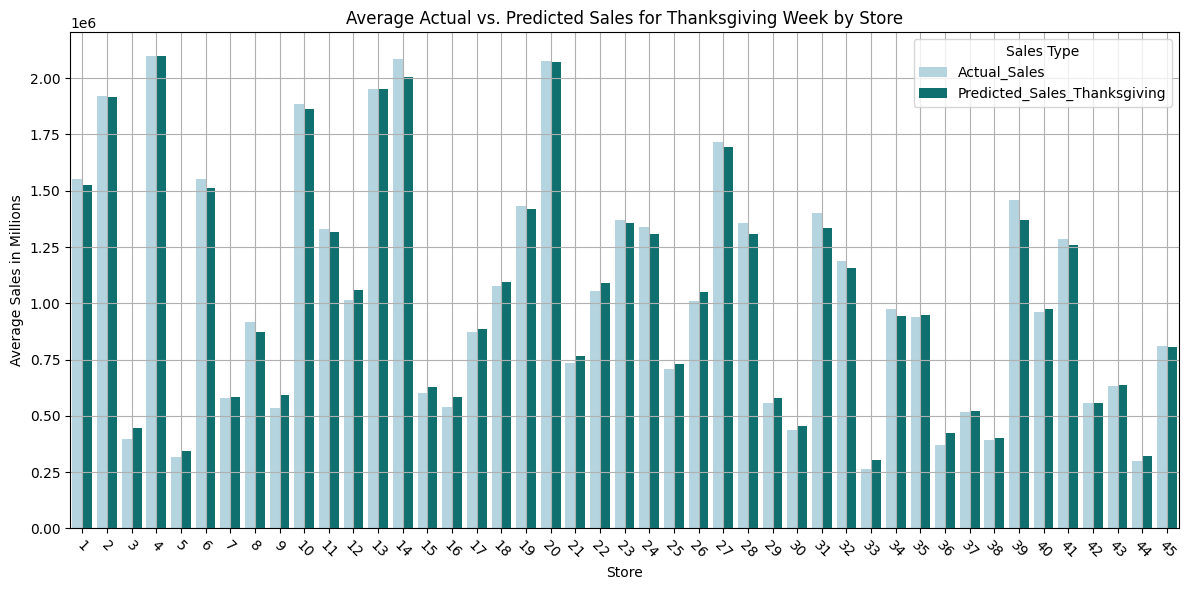

In [33]:
# Add store information to X_test
X_test['Actual_Sales'] = y_test.values
X_test['Predicted_Sales_Thanksgiving'] = predicted_sales_thanksgiving

# Aggregate data by store
store_agg = X_test.groupby('Store').agg({
    'Actual_Sales': 'mean',
    'Predicted_Sales_Thanksgiving': 'mean'
}).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=store_agg.melt(id_vars='Store', var_name='Sales_Type', value_name='Sales'),
            x='Store', y='Sales', hue='Sales_Type',
            palette={'Actual_Sales': 'lightblue', 'Predicted_Sales_Thanksgiving': 'teal'})
plt.xlabel('Store')
plt.ylabel('Average Sales in Millions')
plt.title('Average Actual vs. Predicted Sales for Thanksgiving Week by Store')
plt.xticks(rotation=-45)  # Rotate x-axis labels at -45 degrees
plt.legend(title='Sales Type')
plt.grid(True)
plt.tight_layout()
plt.show()

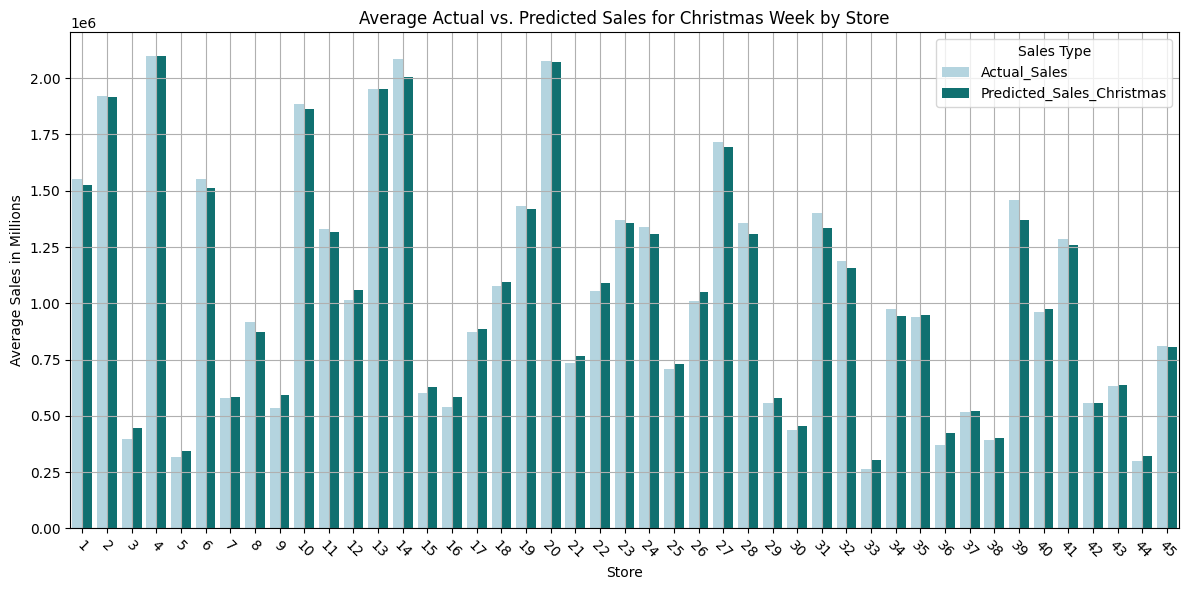

In [34]:
# Add store information to X_test_christmas
X_test_christmas['Actual_Sales'] = y_test.values
X_test_christmas['Predicted_Sales_Christmas'] = predicted_sales_christmas

# Aggregate data by store
store_agg_christmas = X_test_christmas.groupby('Store').agg({
    'Actual_Sales': 'mean',
    'Predicted_Sales_Christmas': 'mean'
}).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=store_agg_christmas.melt(id_vars='Store', var_name='Sales_Type', value_name='Sales'),
            x='Store', y='Sales', hue='Sales_Type',
            palette={'Actual_Sales': 'lightblue', 'Predicted_Sales_Christmas': 'teal'})
plt.xlabel('Store')
plt.ylabel('Average Sales in Millions')
plt.title('Average Actual vs. Predicted Sales for Christmas Week by Store')
plt.xticks(rotation=-45)  # Rotate x-axis labels at -45 degrees
plt.legend(title='Sales Type')
plt.grid(True)
plt.tight_layout()
plt.show()


##Summary of Findings

- **Dataset Overview:**
  - The dataset includes historical sales data for 45 Walmart stores across various regions from 2010-02-05 to 2012-11-01. It contains economic factors, holiday information, and promotional markdown events that may affect sales. The goal is to develop a model to improve sales and demand prediction accuracy, optimizing inventory management, staffing, and marketing strategies.

- **Key Insights:**

  - **Sales Trends:**
    - **Seasonal Peaks:** Peak sales are initially observed in April to July. Upon further review, the absence of January 2010 and December 2012 data means these conclusions should be cautiously interpreted.
    - **Overall Sales Impact:** Despite the absence of January 2010 and December 2012 data, historical sales trends in December 2010 and 2011 show significant peaks, indicating the importance of this month for sales.

  - **Year 2010 Analysis (Feb 5 - Dec 31)**:
    - **Holiday Impact:** Average weekly sales during holidays were $1,112,358.88 compared to 1,054,879.56 on non-holidays.
    - **Seasonal Sales:** Spring had the highest total sales of 652,883,374.15.
    - **Monthly Sales:** December had the highest total sales of 288,760,532.72.
    - **Top Performing Store:** Store 14 had the highest total sales of 105,462,242.38.

  - **Year 2011 Analysis**:
    - **Holiday Impact:** Average weekly sales during holidays were 1,148,530.48 compared to 1,037,715.06 on non-holidays.
    - **Seasonal Sales:** Fall had the highest total sales of 643,374,965.69.
    - **Monthly Sales:** December had the highest total sales of 288,078,102.48.
    - **Top Performing Store:** Store 4 had the highest total sales of 111,092,293.33.

  - **Year 2012 Analysis (Jan 1 - Nov 1):**
    - **Holiday Impact:** Average weekly sales during holidays were 1,092,660.75 compared to 1,030,782.33 on non-holidays.
    - **Seasonal Sales:** Summer had the highest total sales of 655,536,260.24.
    - **Monthly Sales:** June had the highest total sales of 240,610,329.29.
    - **Top Performing Store:** Store 4 had the highest total sales of 92,771,189.24.

  - **Overall Analysis:**
    - **Holiday Impact:** There is a consistent observed effect of holidays on increasing weekly sales across the years.
    - **Seasonal Trends:** Overall, Spring, Fall, and Summer are identified as peak seasons for sales.
    - **Monthly Peaks:** December shows consistently high sales in 2010 and 2011, indicating a strong seasonal trend despite missing December 2012 data.
    - **Top Performing Stores:** Store 14 in 2010 and Store 4 in 2011 and 2012 are identified as high-performing stores, suggesting potential areas for resource allocation and strategy development.

- **Feature Importance:**

  - Based on selection tests, key predictive features are:
    - Store
    - CPI
    - Unemployment
    - Month
    - WeekOfYear

##Model Evaluation and Selection

- **Model Performance:**
  - **Linear Regression:** Weak predictive performance with high errors and low R². Not recommended.
  - **Random Forest Regressor:** Strong performance with low errors and high R². Recommended.
  - **Gradient Boosting Regressor:** Good performance with low errors and high R². Recommended.
  - **Support Vector Regressor (SVR):** Poor performance with high errors and negative R². Not recommended.

- **Model Selection Rationale:**
  - **Gradient Boosting Regressor after Hyperparameter Tuning:** Showed the best performance with:
    - **Mean Squared Error (MSE):** 7790984221.2238
    - **R² Score:**  0.9756
    - **MAPE:**  5.76%
    - **Sales Predictions during Christmas:** Predicted sales increases were analyzed, showing a strong predictive capability.
  - **Predictions:**
    - The Gradient Boosting Regressor model accurately predicts sales increases during specified time frame. With the simulation of markdown scenarios, the model can forecast the impact of promotions and holiday-specific consumer behavior on sales. This capability empowers the business to proactively adjust inventory, staffing, promotional strategies for optimal perormance during high-demand periods.

##Implications and Recommendations

- **Business Insights:**
  - **Inventory Management:** Identified seasonal peaks and holiday impacts can help Walmart optimize inventory levels, ensuring sufficient stock during high-demand periods.
  - **Staffing and Promotions:** Understanding peak seasons and high-performing stores can guide staffing decisions and targeted marketing strategies, enhancing operational efficiency.
  - **Store Performance:** Focus on top-performing stores to identify and replicate successful strategies across other locations.

##Limitations and Future Directions:
- **Study Limitations:**
  - **Data Gaps:** Missing January 2010 and December 2012 data may slightly impact the overall seasonal trend analysis, but the historical data from December 2010 and 2011 provides valuable insights.
  - **Scope and Size:** Further validation with more recent data could improve the model's robustness and generalizability.

- **Future Research Directions:**
  - **Advanced Techniques:** Exploring additional machine learning techniques or ensemble methods could further enhance predictive accuracy.
  - **Real-time Modeling:** Integrating real-time predictive modeling with business intelligence systems could offer enhanced decision support for retail management.
